In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import LeaveOneOut
import seaborn

%matplotlib inline

In [2]:
data_cam_df = pd.read_csv('xcms_pigs_camera.csv', sep = ',', index_col=0)

In [3]:
service_cols = ["mz", "mzmin", "mzmax", "rt", "rtmin", "rtmax", ".", "npeaks", "isotopes", "adduct", "pcgroup"]
assert len(set(service_cols) - set(data_cam_df.columns))==0
samples_cols = list(set(data_cam_df.columns) - set(service_cols))

In [4]:
data_cam_df[data_cam_df==0]=np.nan
data_cam_df[samples_cols] = np.log(data_cam_df[samples_cols])

## standards

#### TAG

In [5]:
new_mz_palm = np.abs((data_cam_df['mz'] - 811.765)) / 811.765 
new_mz_palm = new_mz_palm * 1000000
sunf_ppm_palm = data_cam_df[new_mz_palm<13]

In [6]:
sunf_ppm_palm.head()
sunf_ppm_palm.index

Int64Index([2011], dtype='int64')

In [7]:
RO=pd.Series([i.split('_')[3][1:] if 'S' in i else i for i in data_cam_df.columns],index=data_cam_df.columns)

In [8]:
for i in RO.index:
    try:
        RO[i]=int(RO[i])
    except:
        RO[i]=np.nan

In [9]:
RO=RO.dropna()

#### LPS

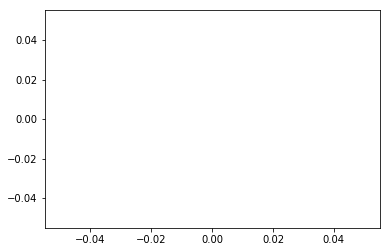

In [10]:
plt.scatter(RO,data_cam_df.loc[1,RO.index], color = 'rebeccapurple')

#### filtration by rt
rt(sec) -> rt(min)

In [11]:
rt_in_min = data_cam_df['rt']/60
data_cam_df['rt'] = rt_in_min
data_cam_filt_rt_df = data_cam_df[(data_cam_df['rt'] > 0.6) & (data_cam_df['rt'] < 19)]
data_cam_filt_rt_df.head(4)

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171206_pigs_scat1_3_15_pos_1.100,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_15_1.100_pos,X171208_pigs_scat2_18_1.100_pos,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup
1,130.158684,130.158150,130.159207,0.660983,38.049,127.265,79,75,11.640429,12.005639,...,11.927535,11.867717,12.015332,12.048855,11.646204,12.103320,11.972464,NaN,NaN,105
2,133.100423,133.099922,133.101013,3.391133,202.231,204.805,69,69,10.248525,11.050215,...,10.273095,9.808182,10.138165,9.222282,10.018860,10.075920,9.181783,NaN,[M+3H-C6H10O4]3+ 542.333,37
3,147.064214,147.063614,147.064651,0.970192,56.181,61.209,74,73,11.269131,8.689696,...,9.952731,9.736448,10.247801,9.891781,10.268355,9.772705,9.975347,NaN,[M+3H-CH2]3+ 452.189 [M+2H-C6H8O6]2+ 468.159,17
4,149.022196,149.021515,149.022699,4.672275,268.144,286.492,140,75,14.002570,13.957953,...,14.030105,14.237696,14.040697,14.005739,14.212340,14.243009,14.031754,NaN,NaN,61


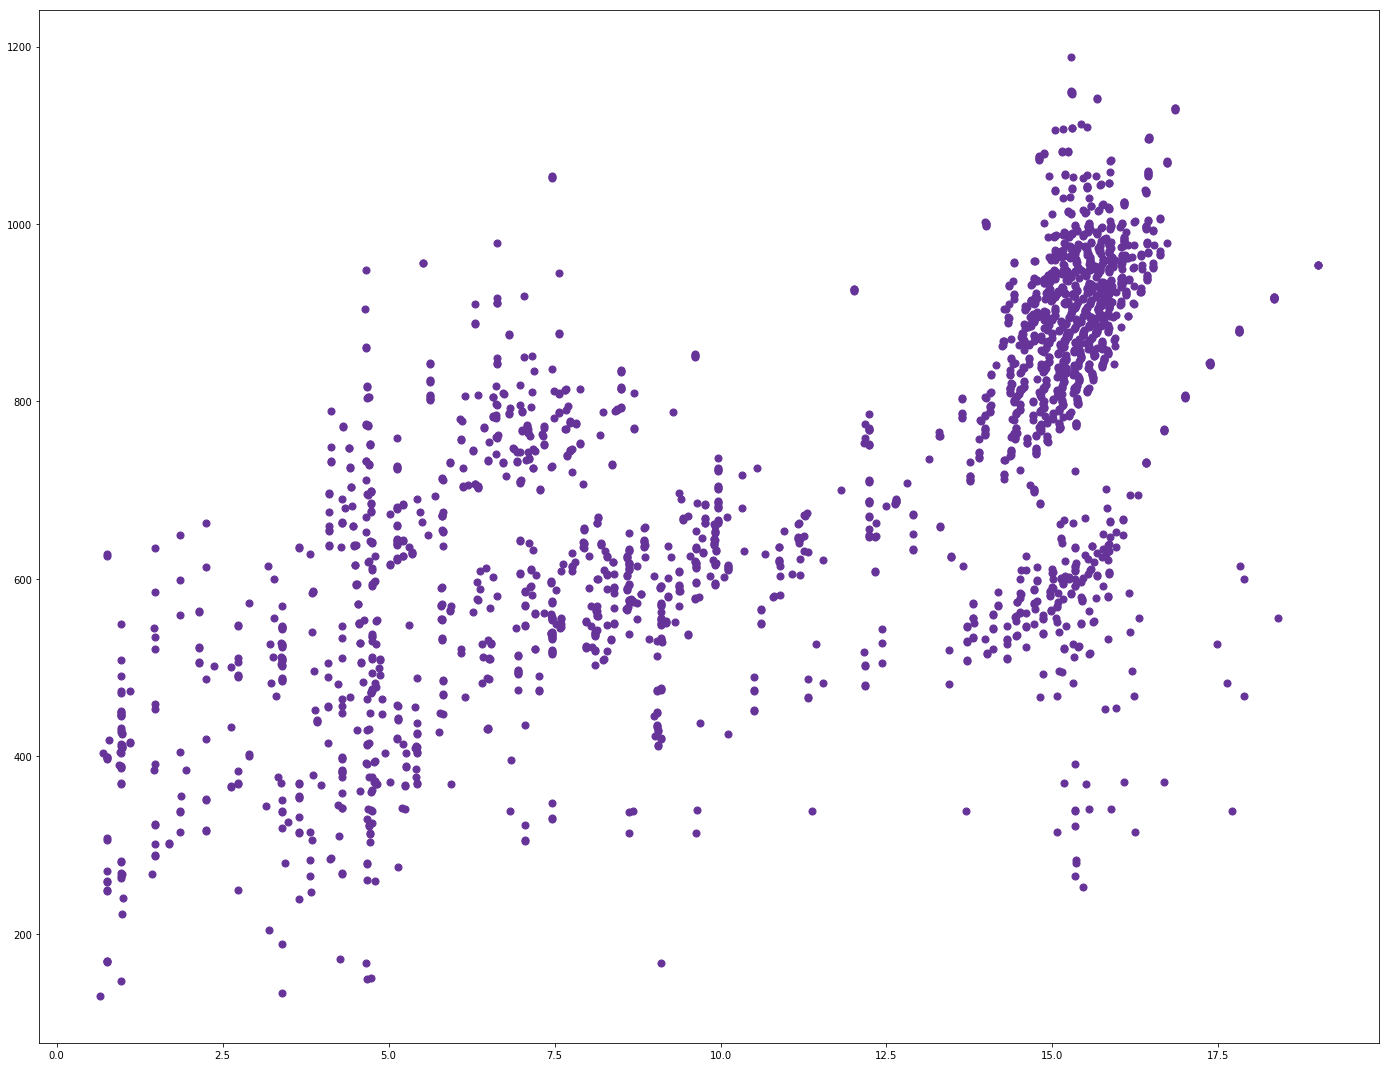

In [12]:
plt.gcf().set_size_inches(24,19)
plt.scatter(data_cam_filt_rt_df['rt'], data_cam_filt_rt_df['mz'], color = 'rebeccapurple', s = 50)

In [13]:
del_isotopes = data_cam_filt_rt_df['isotopes'].str.match(r'\[\d+\]\[M\+\d+\]\+').fillna(False)
#[m][M+n]+ где n от 1, m from 1
data_cam_filt_rt_iso_df = data_cam_filt_rt_df[~del_isotopes]

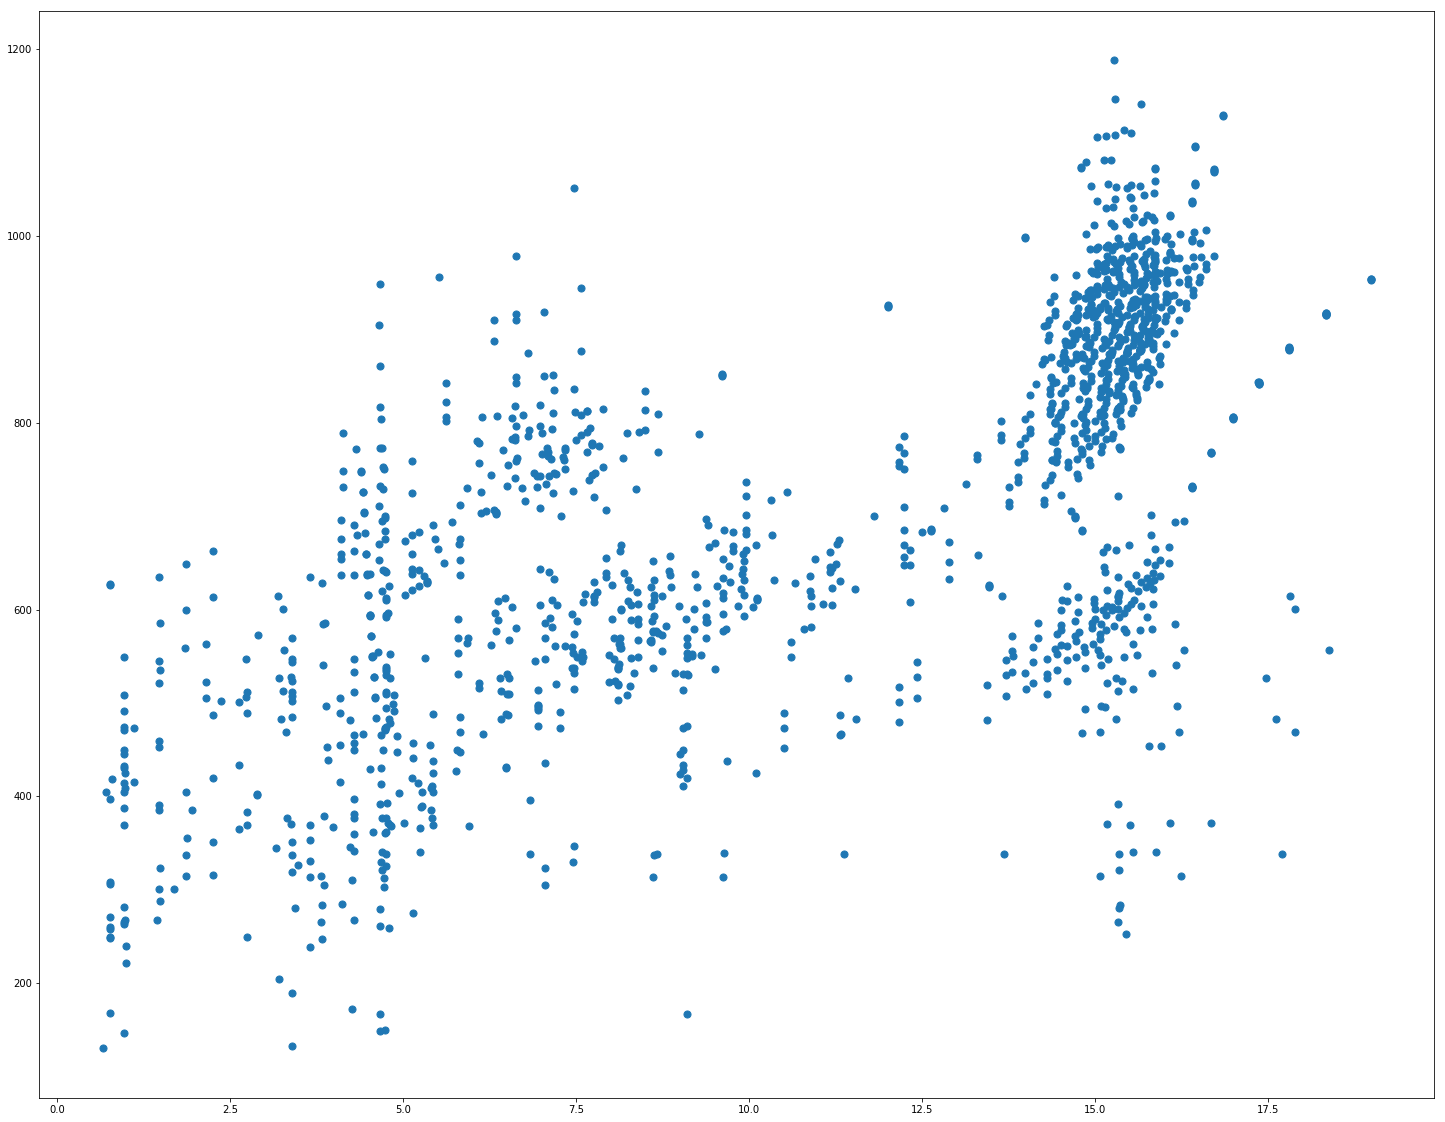

In [14]:
plt.gcf().set_size_inches(25,20)
plt.scatter(data_cam_filt_rt_iso_df['rt'], data_cam_filt_rt_iso_df['mz'], s = 50)



### PCA

In [15]:
lm1_samples = data_cam_filt_rt_iso_df[[col for col in samples_cols if 'LM1' in col]]
lm2_samples = data_cam_filt_rt_iso_df[[col for col in samples_cols if 'LM2'  in col]]
lm3_samples = data_cam_filt_rt_iso_df[[col for col in samples_cols if 'LM3' in col]]
bf1_samples = data_cam_filt_rt_iso_df[[col for col in samples_cols if 'BF1' in col]]
bf2_samples = data_cam_filt_rt_iso_df[[col for col in samples_cols if 'BF2' in col]]
bf3_samples = data_cam_filt_rt_iso_df[[col for col in samples_cols if 'BF3' in col]]
scat1_samples = data_cam_filt_rt_iso_df[[col for col in samples_cols if 'scat1' in col]]
scat2_samples = data_cam_filt_rt_iso_df[[col for col in samples_cols if 'scat2' in col]]

In [16]:
samples_filled_nan = data_cam_filt_rt_iso_df[samples_cols].fillna(0).transpose().as_matrix()

In [17]:
pca = PCA(2)

transformed_samples = pca.fit_transform(samples_filled_nan)

In [18]:
transformed_samples_df = pd.DataFrame(transformed_samples.T, columns = samples_cols)

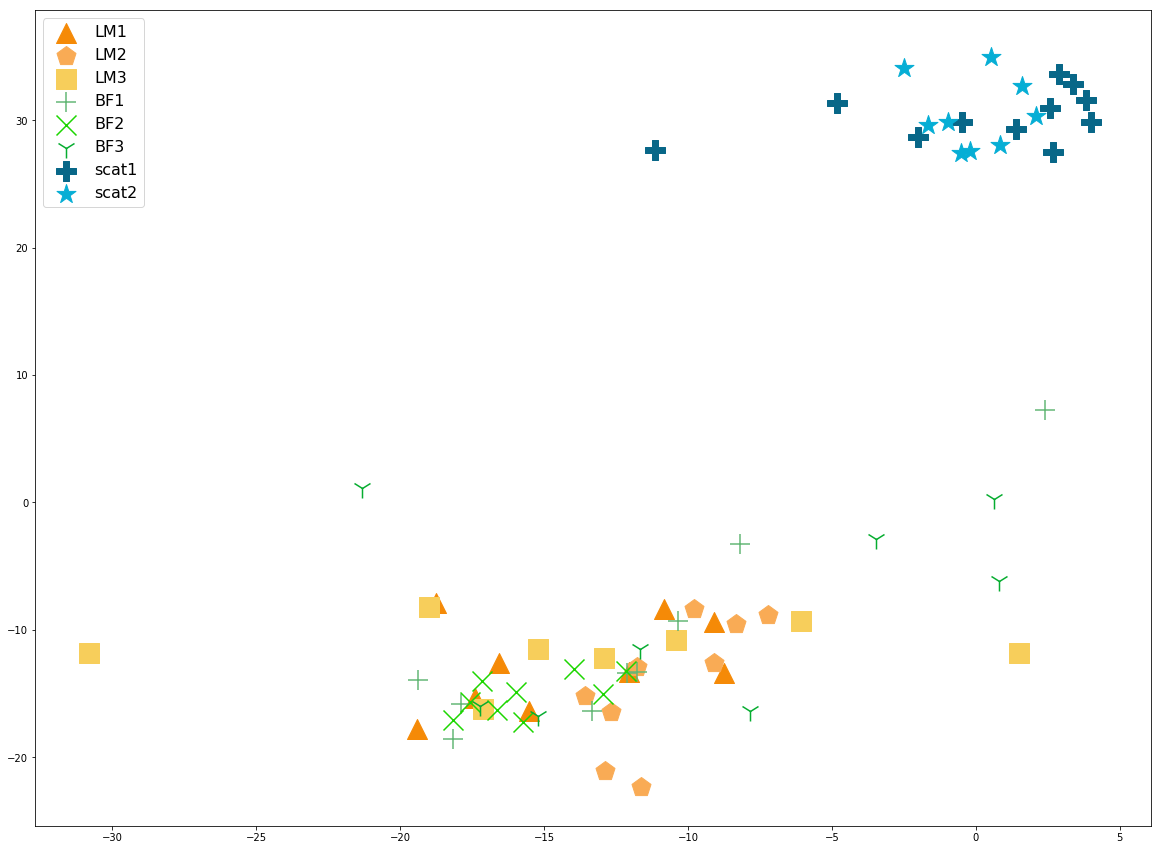

In [19]:
plt.gcf().set_size_inches(20,15)
s=400
plt.scatter(transformed_samples_df[lm1_samples.columns].loc[0], transformed_samples_df[lm1_samples.columns].loc[1],
             s = s, facecolors='#F58A07',  label="LM1", marker='^')
plt.scatter(transformed_samples_df[lm2_samples.columns].loc[0], transformed_samples_df[lm2_samples.columns].loc[1],
             s = s, facecolors='#F9AB55',  label="LM2", marker='p')
plt.scatter(transformed_samples_df[lm3_samples.columns].loc[0], transformed_samples_df[lm3_samples.columns].loc[1],
             s = s, facecolors='#F7CE5B',  label="LM3", marker='s')
plt.scatter(transformed_samples_df[bf1_samples.columns].loc[0], transformed_samples_df[bf1_samples.columns].loc[1],
             s = s, facecolors='#63B775', label="BF1", marker='+')
plt.scatter(transformed_samples_df[bf2_samples.columns].loc[0], transformed_samples_df[bf2_samples.columns].loc[1],
             s = s, facecolors='#1CD600', label="BF2", marker='x')
plt.scatter(transformed_samples_df[bf3_samples.columns].loc[0], transformed_samples_df[bf3_samples.columns].loc[1],
             s = s, facecolors='#06AD30', label="BF3", marker='1')
plt.scatter(transformed_samples_df[scat1_samples.columns].loc[0], transformed_samples_df[scat1_samples.columns].loc[1],
             s = s, facecolors='#086788',  label="scat1", marker='P')
plt.scatter(transformed_samples_df[scat2_samples.columns].loc[0], transformed_samples_df[scat2_samples.columns].loc[1],
             s = s, facecolors='#06AED5',  label="scat2", marker='*')
plt.legend(prop={'size': 16}) 


In [20]:
def add_mz_rt_cols(df):
    return data_cam_filt_rt_iso_df[df.columns.tolist() + ['mz', 'rt']]

lm1_samples_with_mz_rt = add_mz_rt_cols(lm1_samples)

### after Anya filtering

In [106]:
filtering_res = np.load('cleanedpeaks.npy')

In [107]:
filtering_res_indices = sorted(set(data_cam_filt_rt_iso_df.index) & set(filtering_res))

In [108]:
data_filtering = data_cam_filt_rt_iso_df.loc[filtering_res_indices]

In [109]:
type(data_filtering)

pandas.core.frame.DataFrame

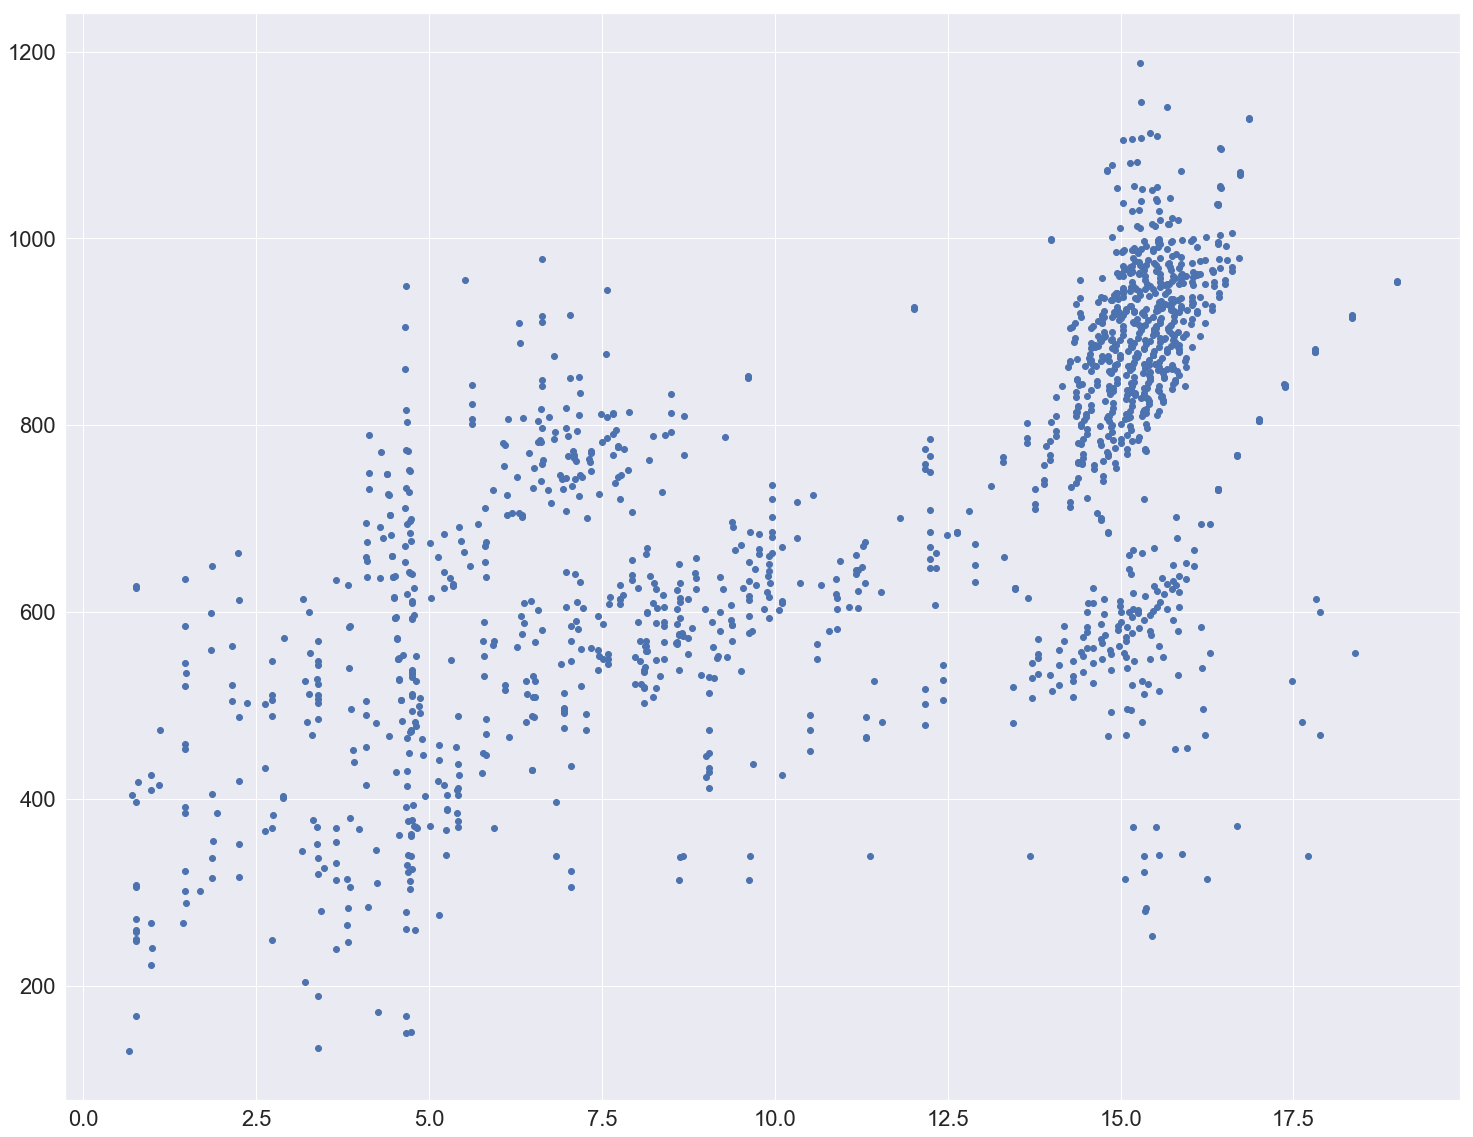

In [110]:
plt.gcf().set_size_inches(25,20)
plt.scatter(data_filtering['rt'], data_filtering['mz'])

## annotation


In [111]:
annot_data = pd.read_csv('xcms_pigs_camera.csv.ann.txt', sep = ',', index_col=0)
#loading data

In [112]:
lmfa_index = annot_data['lm_id'].str.contains('LMFA0101').fillna(False)
#строки в annot_data которые содержать LMFA0101 + что-то
lmfa_annot_data = annot_data[lmfa_index]
lmfa_annot_data = annot_data[lmfa_index]
#беру из annot_data строки которые соответствуют строкам в которых есть LMFA0101 + что-то

In [113]:
annot_data_no_null = annot_data[~annot_data['lm_id'].isnull()]
annot_data_no_null

,lm_id,adduct,ppm
1,LMFA11000592,M+NH4,-3.021140
1,LMFA11000636,M+NH4,-3.021140
1,LMFA11000637,M+NH4,-3.021140
1,LMFA11000638,M+NH4,-3.021140
1,LMFA11000659,M+NH4,-3.021140
3,LMFA01020278,M+H,-6.656413
3,LMFA01050343,M+H,-6.656413
3,LMFA01050383,M+H,-6.656413
3,LMFA01050435,M+H,-6.656413
3,LMFA01050457,M+H,-6.649566


In [114]:
annot_groups = []

for index, data in annot_data_no_null.groupby(annot_data_no_null.index):
    annot_groups.append({
        "index": index,
        "lm_id": ";".join(data.lm_id),
        "adduct_annot": ";".join(data.adduct)
    })
    
annot_groups = pd.DataFrame(annot_groups)
annot_groups.set_index('index', inplace=True)

In [115]:
data_cam_filt_rt_iso_df.index

Int64Index([   1,    2,    3,    4,    5,   11,   12,   13,   16,   23,
            ...
            3058, 3059, 3060, 3062, 3064, 3066, 3067, 3071, 3073, 3078],
           dtype='int64', length=1575)

In [116]:
annot_groups.index

Int64Index([   1,    3,    8,    9,   11,   22,   23,   32,   34,   37,
            ...
            3000, 3005, 3007, 3010, 3037, 3038, 3045, 3055, 3057, 3069],
           dtype='int64', name='index', length=1397)

In [117]:
data_cam_df.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078],
           dtype='int64', length=3078)

In [118]:
data_cam_filt_rt_iso_df_annot = pd.merge(data_cam_filt_rt_iso_df, annot_groups, left_index=True, right_index=True)
data_cam_filt_rt_iso_df_annot

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171206_pigs_scat1_3_15_pos_1.100,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup,adduct_annot,lm_id
1,130.158684,130.158150,130.159207,0.660983,38.049,127.265,79,75,1.135989e+05,163675.176314,...,165269.445760,170903.619818,1.142568e+05,180470.050157,158334.237000,NaN,NaN,105,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMFA11000592;LMFA11000636;LMFA11000637;LMFA110...
3,147.064214,147.063614,147.064651,0.970192,56.181,61.209,74,73,7.836488e+04,5941.377067,...,28220.408000,19767.224820,2.880648e+04,17548.174968,21490.087784,NaN,[M+3H-CH2]3+ 452.189 [M+2H-C6H8O6]2+ 468.159,17,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H,LMFA01020278;LMFA01050343;LMFA01050383;LMFA010...
11,167.033147,167.032459,167.044086,4.664467,268.411,353.477,173,76,5.383955e+05,344213.516167,...,538610.274250,518295.474000,5.393251e+05,632316.958708,515143.321000,NaN,[M+K]+ 128.075,61,M+Na;M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01020394;LMFA01170068;LMFA01170070;LMFA011...
23,189.111163,189.110486,189.111964,3.391100,202.502,204.732,76,75,6.225582e+04,122539.885854,...,54046.826341,11910.765422,4.292887e+04,50676.030667,7667.408800,NaN,[M+2H-C5H8O4]2+ 508.248,37,M+H;M+H;M+H;M+H;M+H,LMFA01030981;LMFA01170054;LMFA07010695;LMFA070...
64,239.235633,239.234987,239.236786,3.651767,217.844,220.309,69,69,1.580640e+04,43406.245000,...,17230.109600,25903.114493,1.447719e+04,16096.901838,17016.748771,NaN,NaN,48,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+...,LMFA05000007;LMFA05000015;LMFA05000023;LMFA050...
77,247.241090,247.239985,247.241918,3.829300,207.270,233.417,122,71,1.580613e+05,174478.761049,...,273182.006941,483621.205082,1.942795e+05,411459.953642,174442.761412,NaN,NaN,111,M+H;M+H,LMFA11000057;LMPR0103500002
80,249.111112,249.109942,249.111911,2.736883,162.912,165.385,68,68,2.415003e+04,6083.217000,...,29107.586595,24133.850222,2.165971e+04,20440.404148,25794.685700,NaN,NaN,74,M+Na;M+Na;M+Na;M+Na,LMFA01170130;LMFA02020007;LMFA02020008;LMFA020...
88,253.088412,253.087189,253.089254,15.456933,896.979,951.987,166,70,2.151456e+04,26997.337263,...,25386.933000,28783.984229,3.568933e+03,27341.361000,34320.624824,NaN,NaN,1,M+H;M+H;M+H,LMPK12050001;LMPK12110021;LMPK12110100
95,259.189212,259.188321,259.190360,4.799233,273.364,291.272,72,67,5.498798e+04,47038.694000,...,65763.418605,32055.494913,3.429097e+04,85737.675385,34328.135859,NaN,NaN,421,M+H;M+H;M+H;M+H;M+H;M+H,LMFA01170015;LMFA01170016;LMFA01170017;LMFA011...
98,261.147355,261.146258,261.148370,4.672900,268.374,286.852,139,75,1.906240e+05,116060.776553,...,203368.349233,188524.971000,1.887536e+05,178745.826581,192029.030283,NaN,NaN,61,M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01060185;LMFA02010010;LMFA02010011;LMFA070...


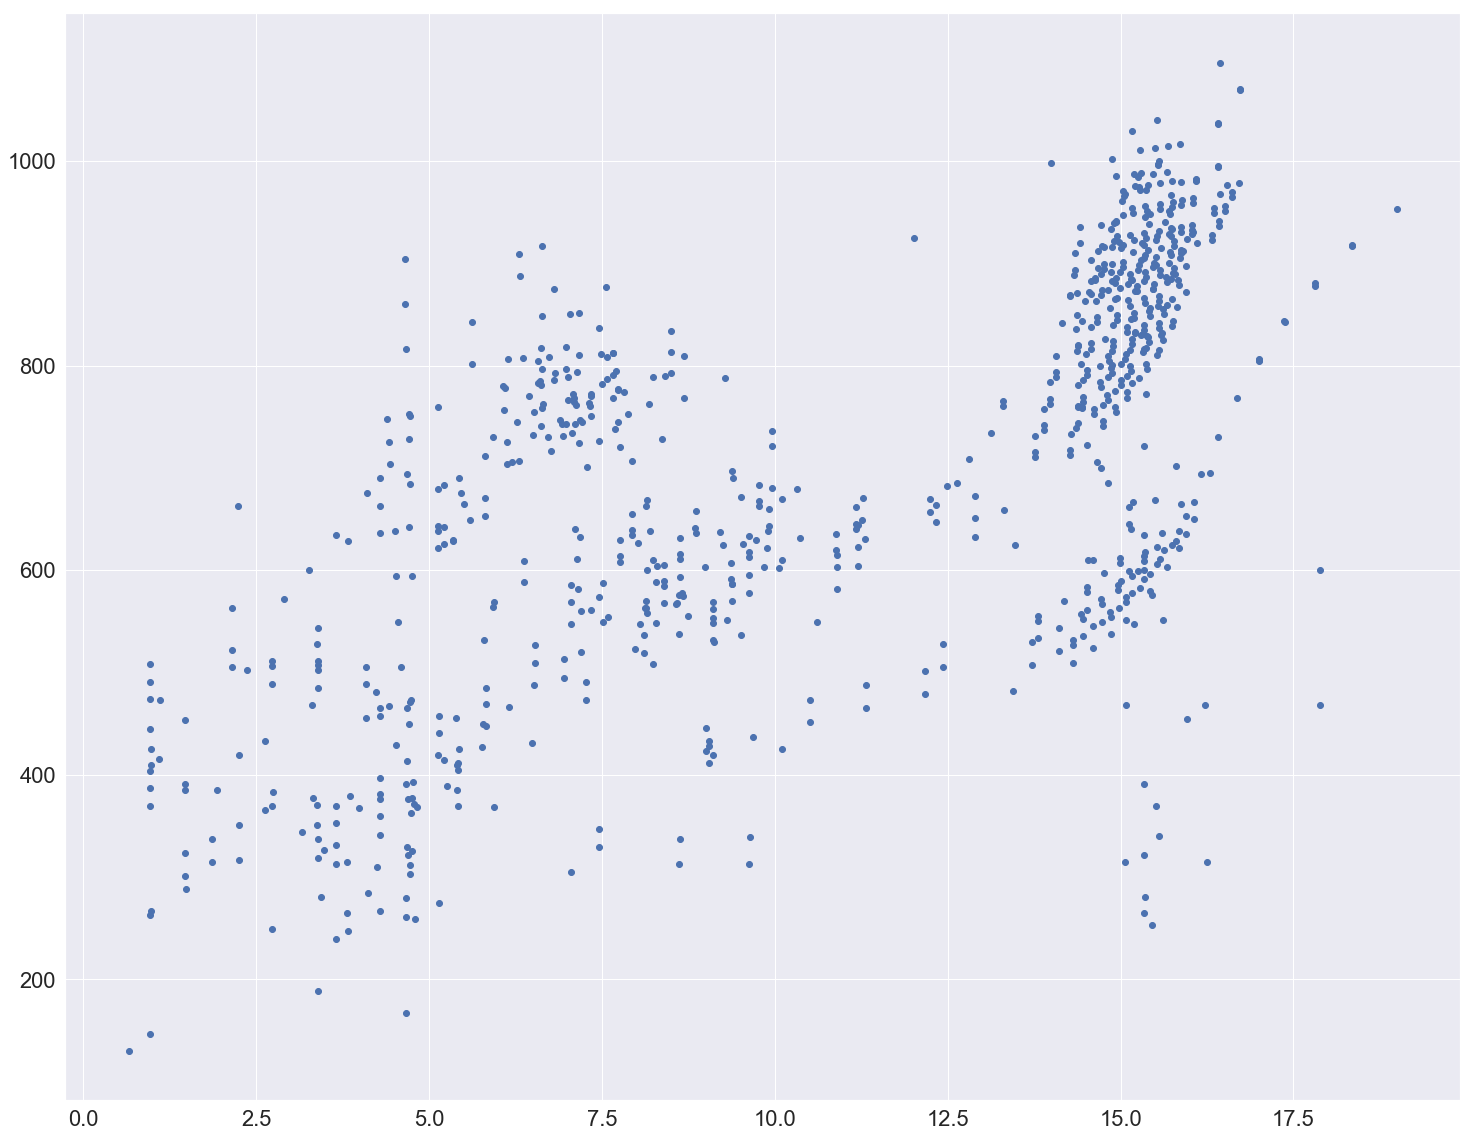

In [119]:
plt.gcf().set_size_inches(25,20)
plt.scatter(data_cam_filt_rt_iso_df_annot['rt'], data_cam_filt_rt_iso_df_annot['mz'])

In [120]:
lmfa_index3 = annot_data['lm_id'].str.contains('LMFA0103').fillna(False)
#строки в annot_data которые содержать LMFA0101 + что-то
lmfa_annot_data3 = annot_data[lmfa_index3]
lmfa_annot_data3 = annot_data[lmfa_index3]
#беру из annot_data строки которые соответствуют строкам в которых есть LMFA0101 + что-то

In [121]:
lmfa_annot_data3

,lm_id,adduct,ppm
8,LMFA01030783,M+H,-3.781975
23,LMFA01030981,M+H,-5.919063
37,LMFA01030240,M+Na,8.363737
37,LMFA01030241,M+Na,8.363737
37,LMFA01030242,M+Na,8.363737
37,LMFA01030464,M+Na,8.363737
118,LMFA01030109,M+Na,-3.746604
118,LMFA01030268,M+Na,-3.746604
118,LMFA01030269,M+Na,-3.746604
118,LMFA01030270,M+Na,-3.746604


In [122]:
data_cam_filt_rt_iso_df_annot

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171206_pigs_scat1_3_15_pos_1.100,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup,adduct_annot,lm_id
1,130.158684,130.158150,130.159207,0.660983,38.049,127.265,79,75,1.135989e+05,163675.176314,...,165269.445760,170903.619818,1.142568e+05,180470.050157,158334.237000,NaN,NaN,105,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMFA11000592;LMFA11000636;LMFA11000637;LMFA110...
3,147.064214,147.063614,147.064651,0.970192,56.181,61.209,74,73,7.836488e+04,5941.377067,...,28220.408000,19767.224820,2.880648e+04,17548.174968,21490.087784,NaN,[M+3H-CH2]3+ 452.189 [M+2H-C6H8O6]2+ 468.159,17,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H,LMFA01020278;LMFA01050343;LMFA01050383;LMFA010...
11,167.033147,167.032459,167.044086,4.664467,268.411,353.477,173,76,5.383955e+05,344213.516167,...,538610.274250,518295.474000,5.393251e+05,632316.958708,515143.321000,NaN,[M+K]+ 128.075,61,M+Na;M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01020394;LMFA01170068;LMFA01170070;LMFA011...
23,189.111163,189.110486,189.111964,3.391100,202.502,204.732,76,75,6.225582e+04,122539.885854,...,54046.826341,11910.765422,4.292887e+04,50676.030667,7667.408800,NaN,[M+2H-C5H8O4]2+ 508.248,37,M+H;M+H;M+H;M+H;M+H,LMFA01030981;LMFA01170054;LMFA07010695;LMFA070...
64,239.235633,239.234987,239.236786,3.651767,217.844,220.309,69,69,1.580640e+04,43406.245000,...,17230.109600,25903.114493,1.447719e+04,16096.901838,17016.748771,NaN,NaN,48,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+...,LMFA05000007;LMFA05000015;LMFA05000023;LMFA050...
77,247.241090,247.239985,247.241918,3.829300,207.270,233.417,122,71,1.580613e+05,174478.761049,...,273182.006941,483621.205082,1.942795e+05,411459.953642,174442.761412,NaN,NaN,111,M+H;M+H,LMFA11000057;LMPR0103500002
80,249.111112,249.109942,249.111911,2.736883,162.912,165.385,68,68,2.415003e+04,6083.217000,...,29107.586595,24133.850222,2.165971e+04,20440.404148,25794.685700,NaN,NaN,74,M+Na;M+Na;M+Na;M+Na,LMFA01170130;LMFA02020007;LMFA02020008;LMFA020...
88,253.088412,253.087189,253.089254,15.456933,896.979,951.987,166,70,2.151456e+04,26997.337263,...,25386.933000,28783.984229,3.568933e+03,27341.361000,34320.624824,NaN,NaN,1,M+H;M+H;M+H,LMPK12050001;LMPK12110021;LMPK12110100
95,259.189212,259.188321,259.190360,4.799233,273.364,291.272,72,67,5.498798e+04,47038.694000,...,65763.418605,32055.494913,3.429097e+04,85737.675385,34328.135859,NaN,NaN,421,M+H;M+H;M+H;M+H;M+H;M+H,LMFA01170015;LMFA01170016;LMFA01170017;LMFA011...
98,261.147355,261.146258,261.148370,4.672900,268.374,286.852,139,75,1.906240e+05,116060.776553,...,203368.349233,188524.971000,1.887536e+05,178745.826581,192029.030283,NaN,NaN,61,M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01060185;LMFA02010010;LMFA02010011;LMFA070...


In [123]:
data_cam_filt_rt_iso_df_annot.drop(["X171208_pigs_scat1_1_15_1.100_pos", "X171208_pigs_scat1_2_15_1.100_pos"], axis = 1, inplace = True)
data_cam_filt_rt_iso_df_annot.rename(columns={"X171208_pigs_LM3_1_11_1.50_pos": "X171208_pigs_LM3_11_1.50_pos",
                                             "X171206_pigs_scat1_3_15_pos_1.100": "X171208_pigs_scat1_15_1.100_pos"}, inplace=True)

In [124]:
import re
part_pattern = re.compile(r"_pigs_(\S+?)_")

def get_pig_part(col_name):
    return part_pattern.search(col_name).group(1)
    
    
parts_mapping = {}
for col in data_cam_filt_rt_iso_df_annot.columns:
    if "QC" in col:
        continue
    
    try:
        parts_mapping.setdefault(get_pig_part(col), []).append(col) 
    except:
        pass

In [125]:
for part, cols in sorted(parts_mapping.items()):
    print(part, len(cols))

BF1 9
BF2 9
BF3 8
LM1 9
LM2 9
LM3 8
scat1 9
scat2 9


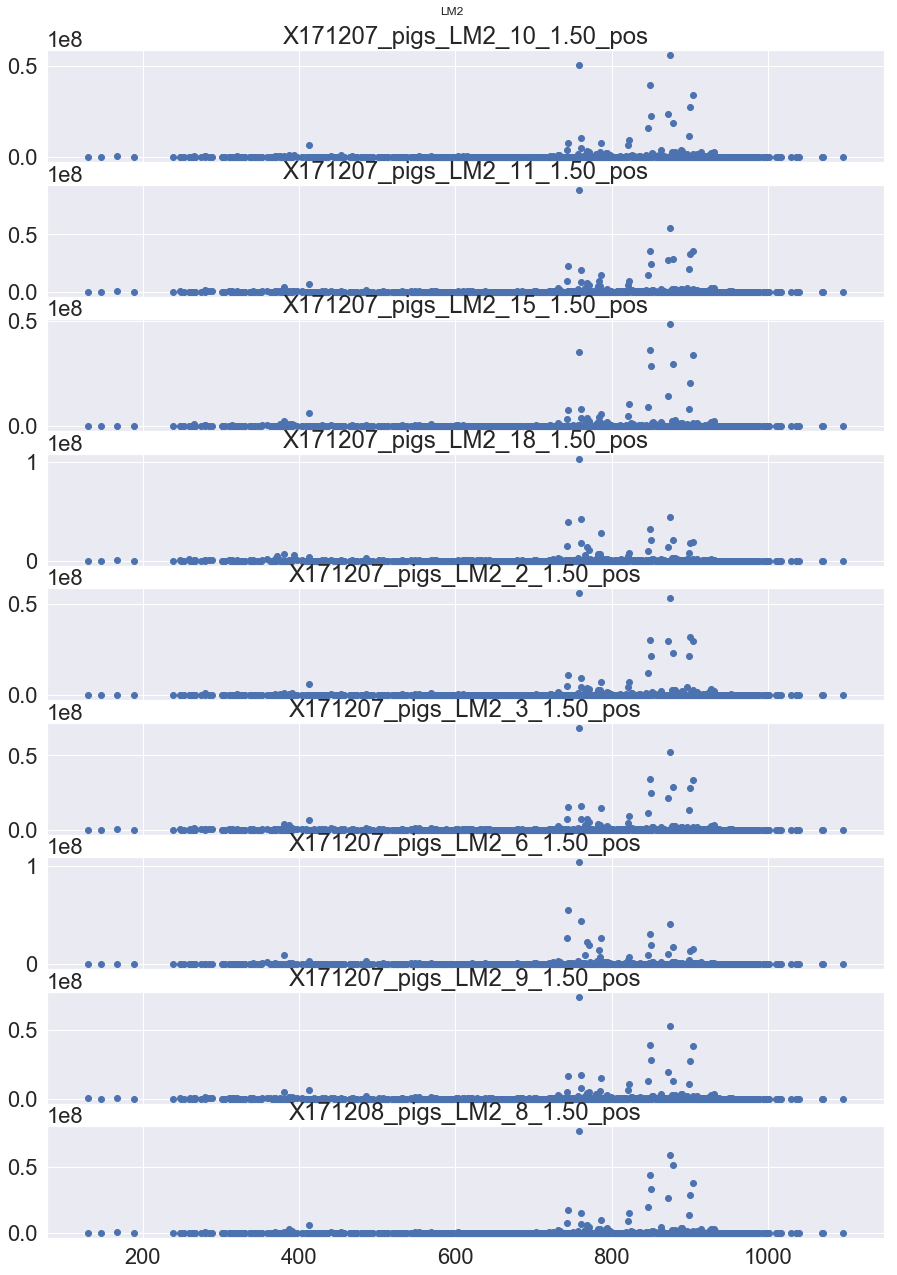

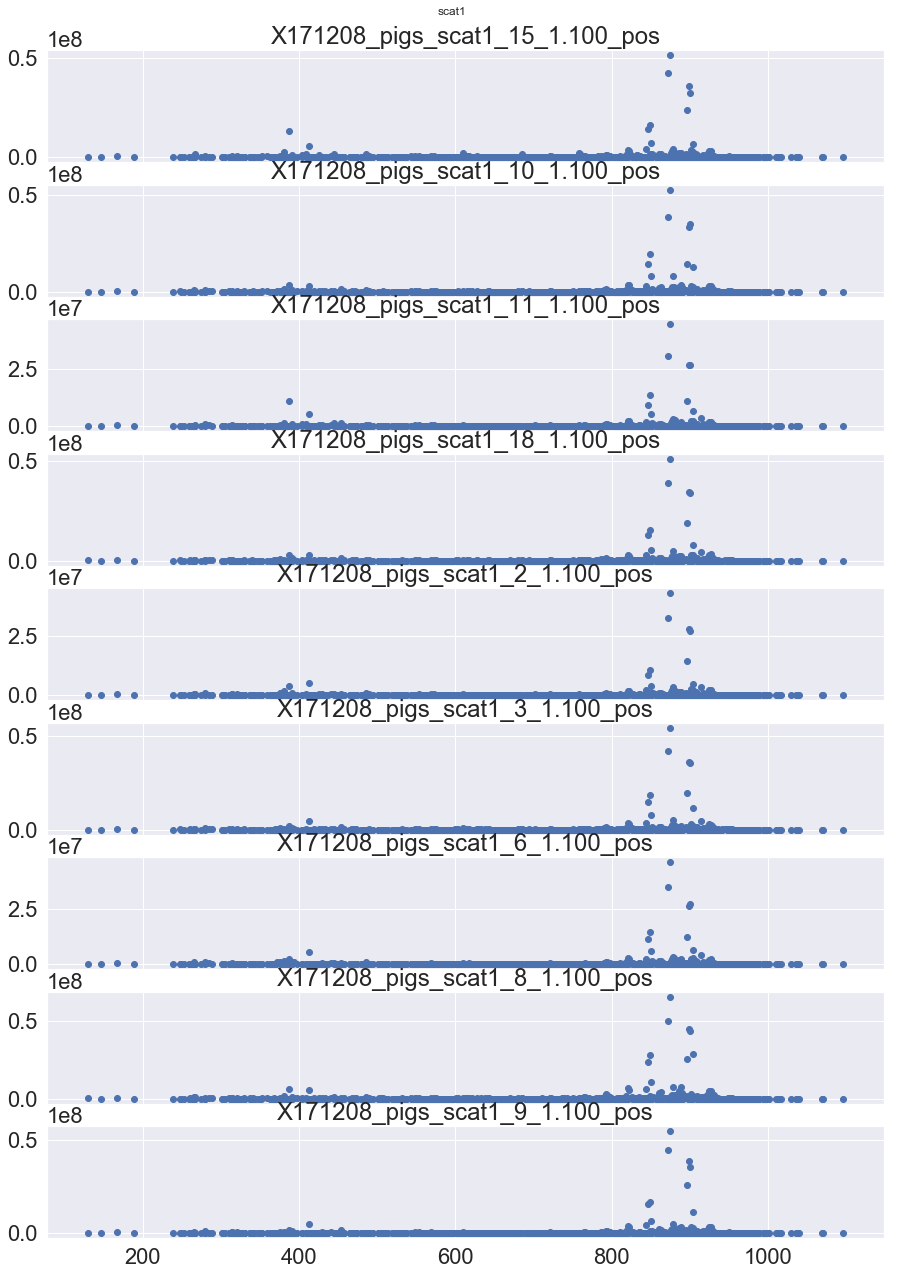

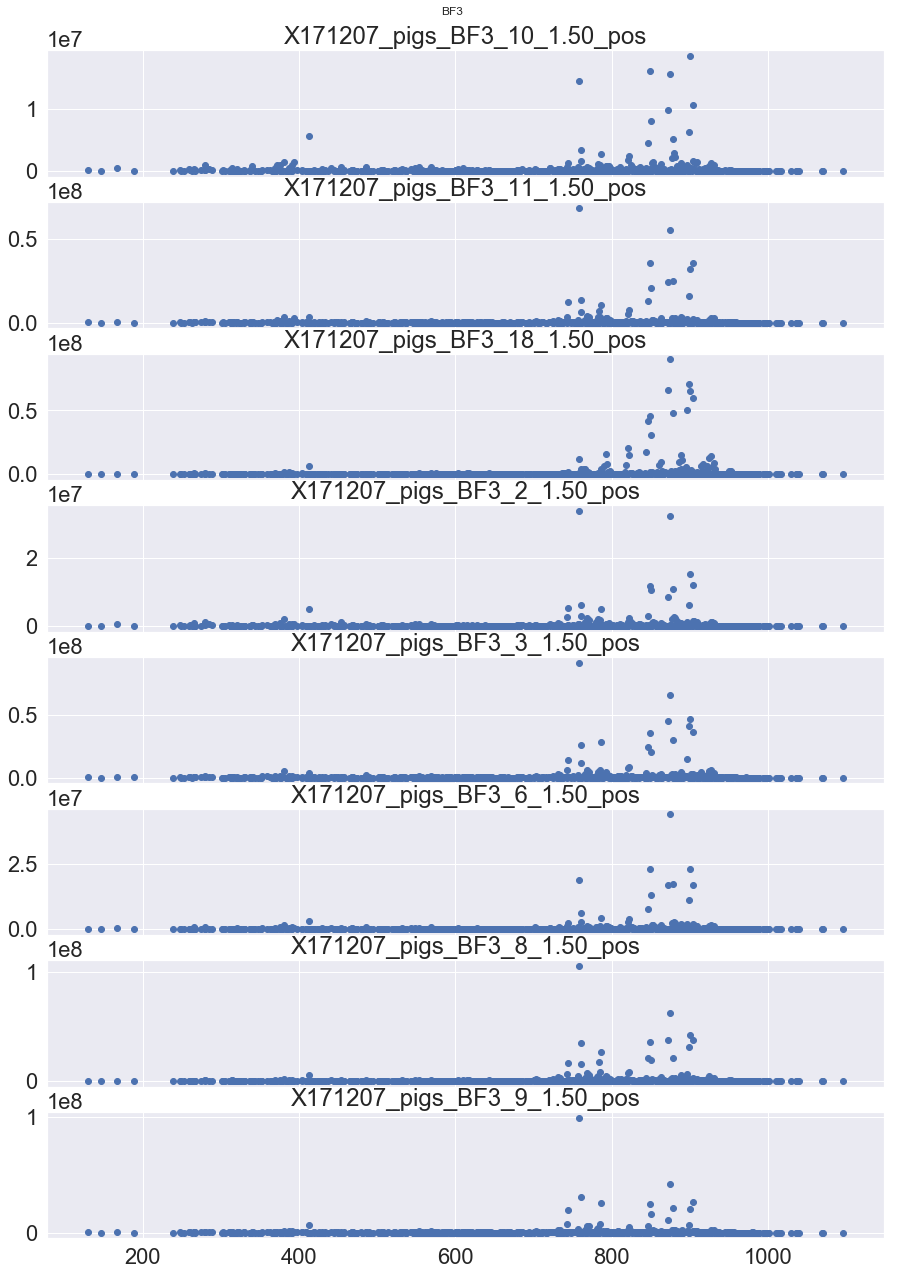

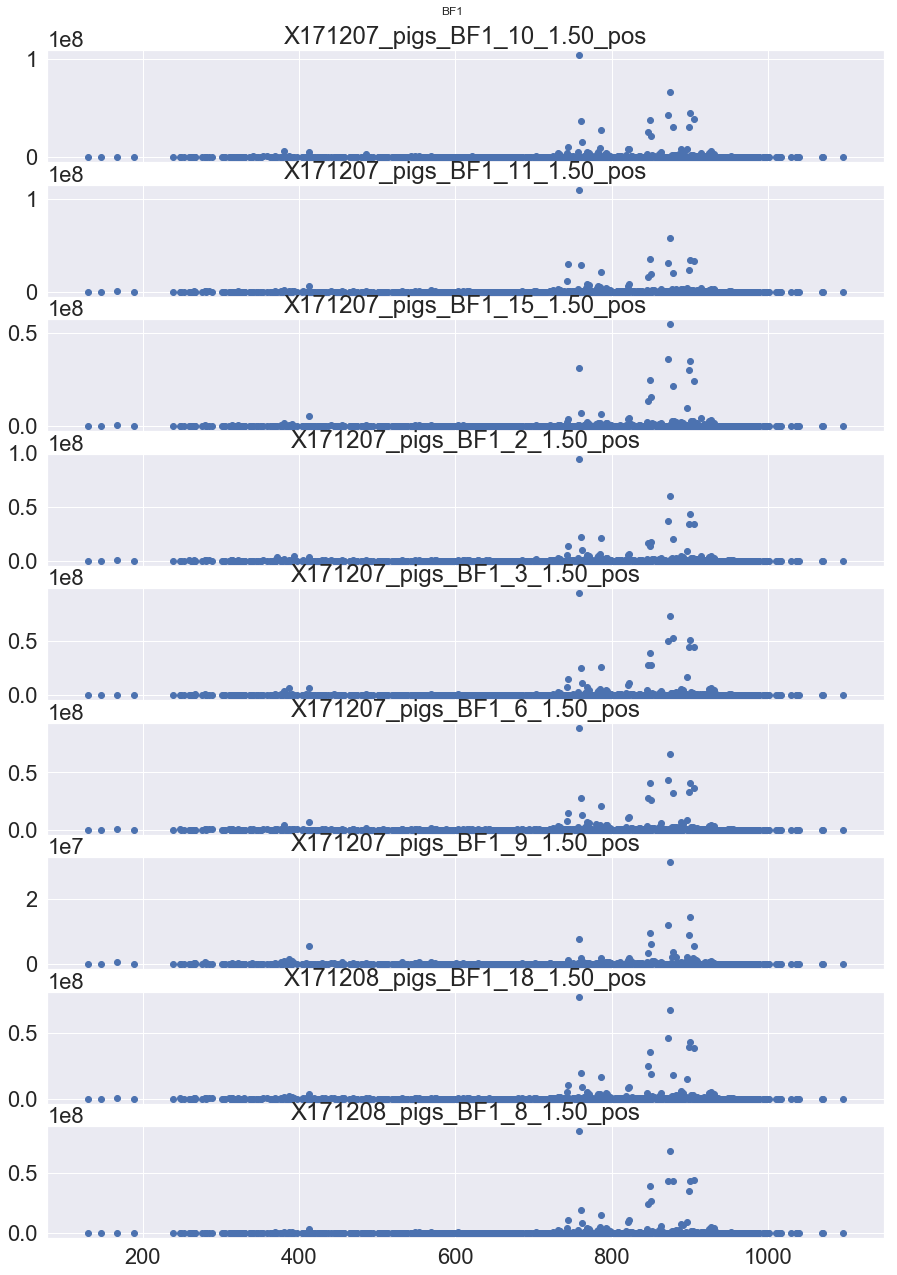

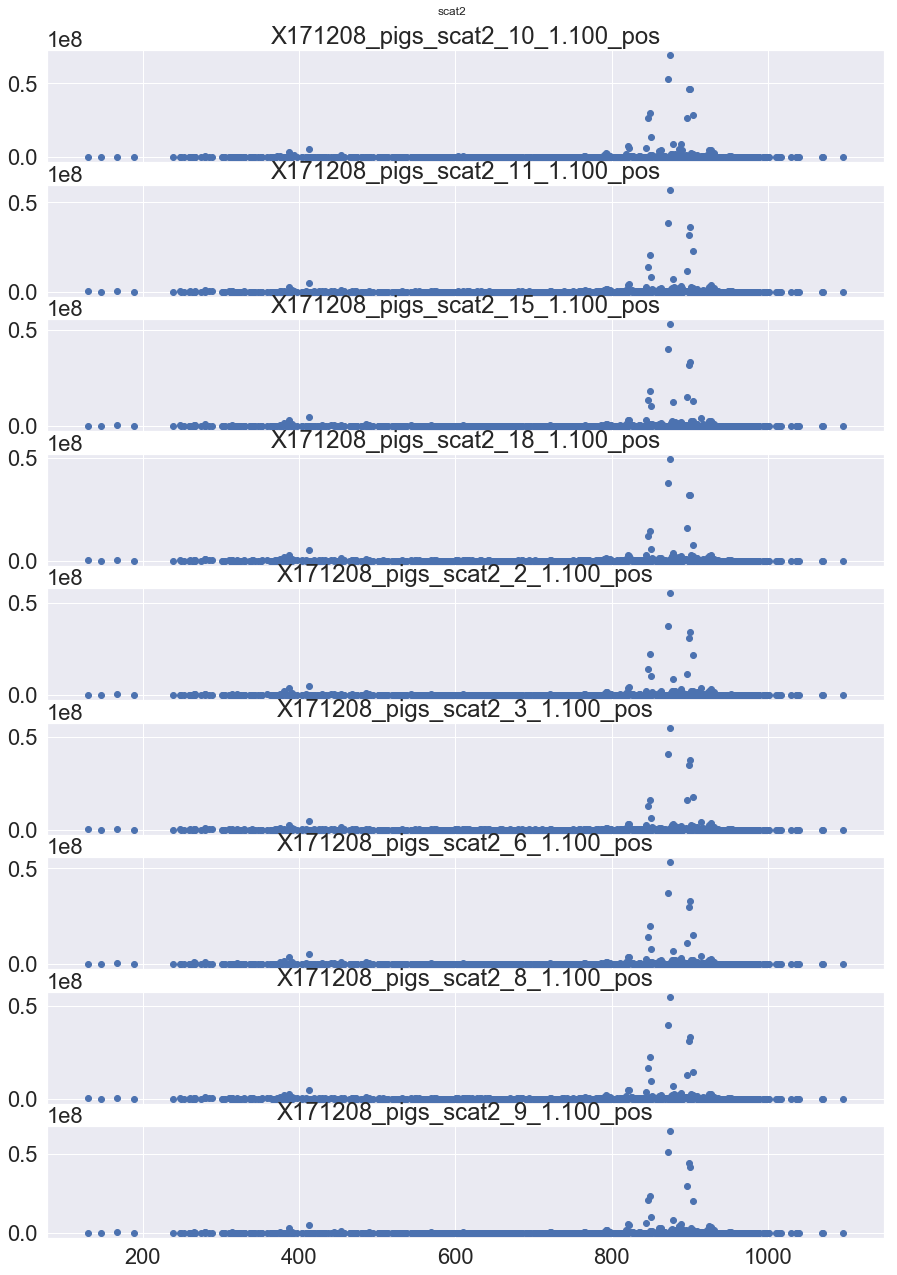

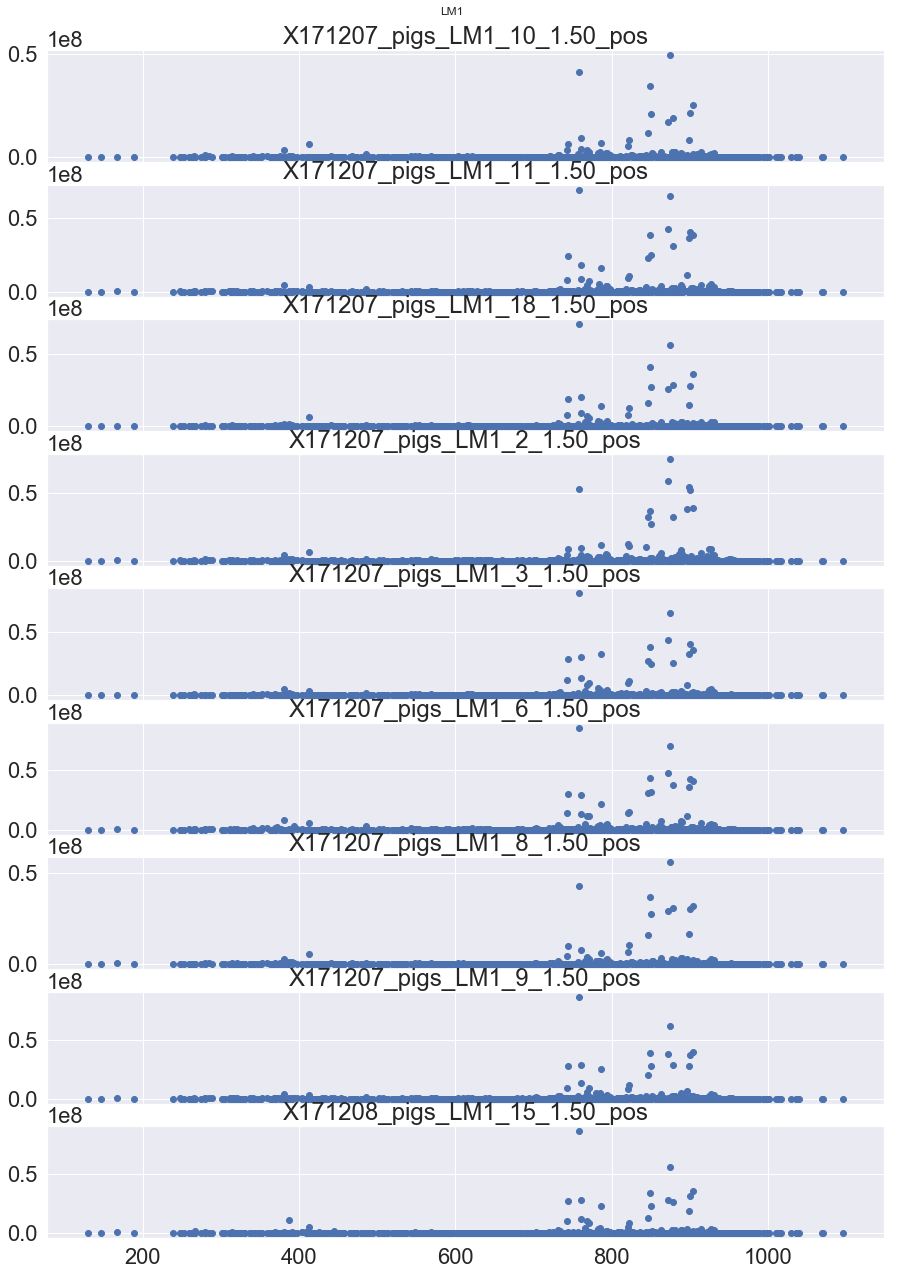

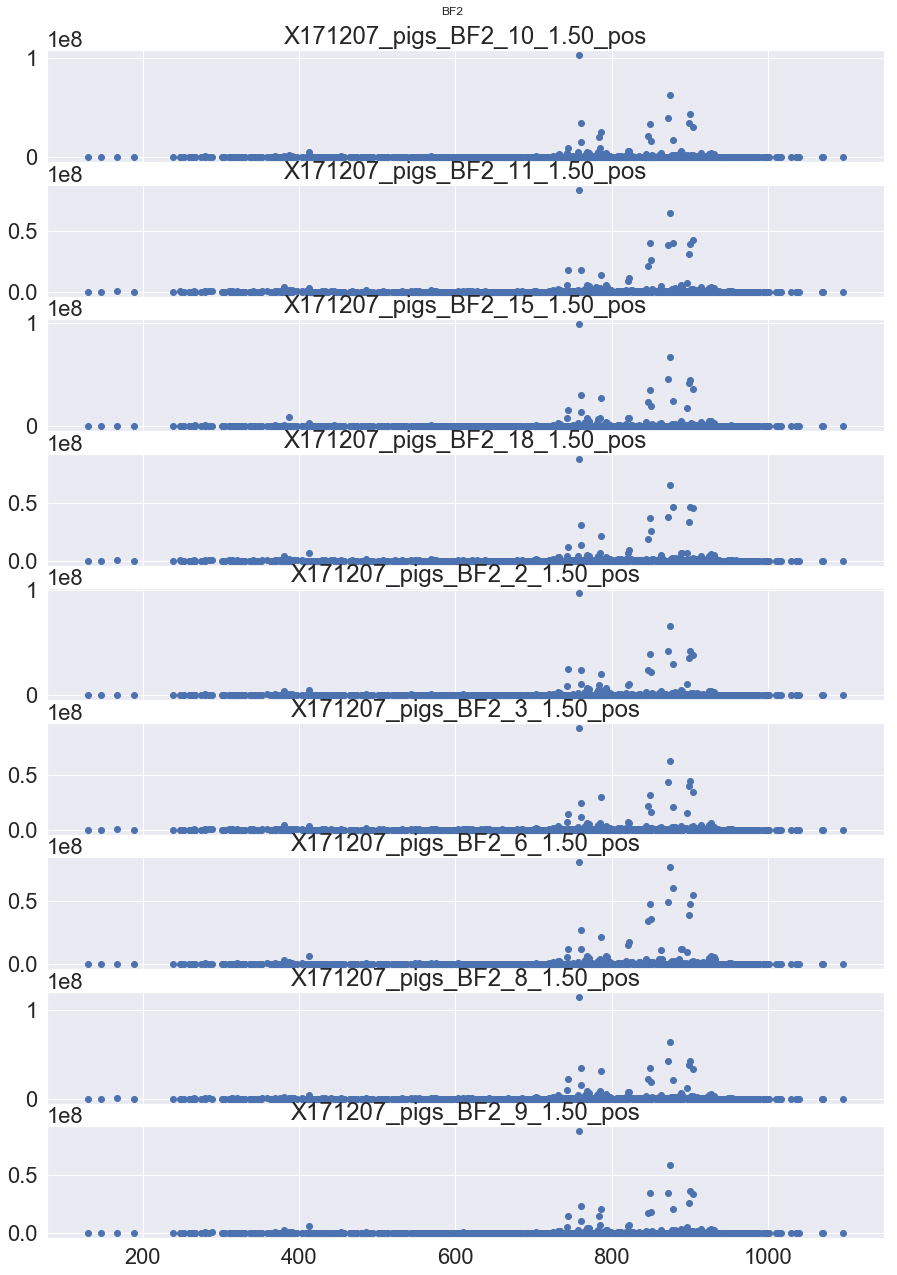

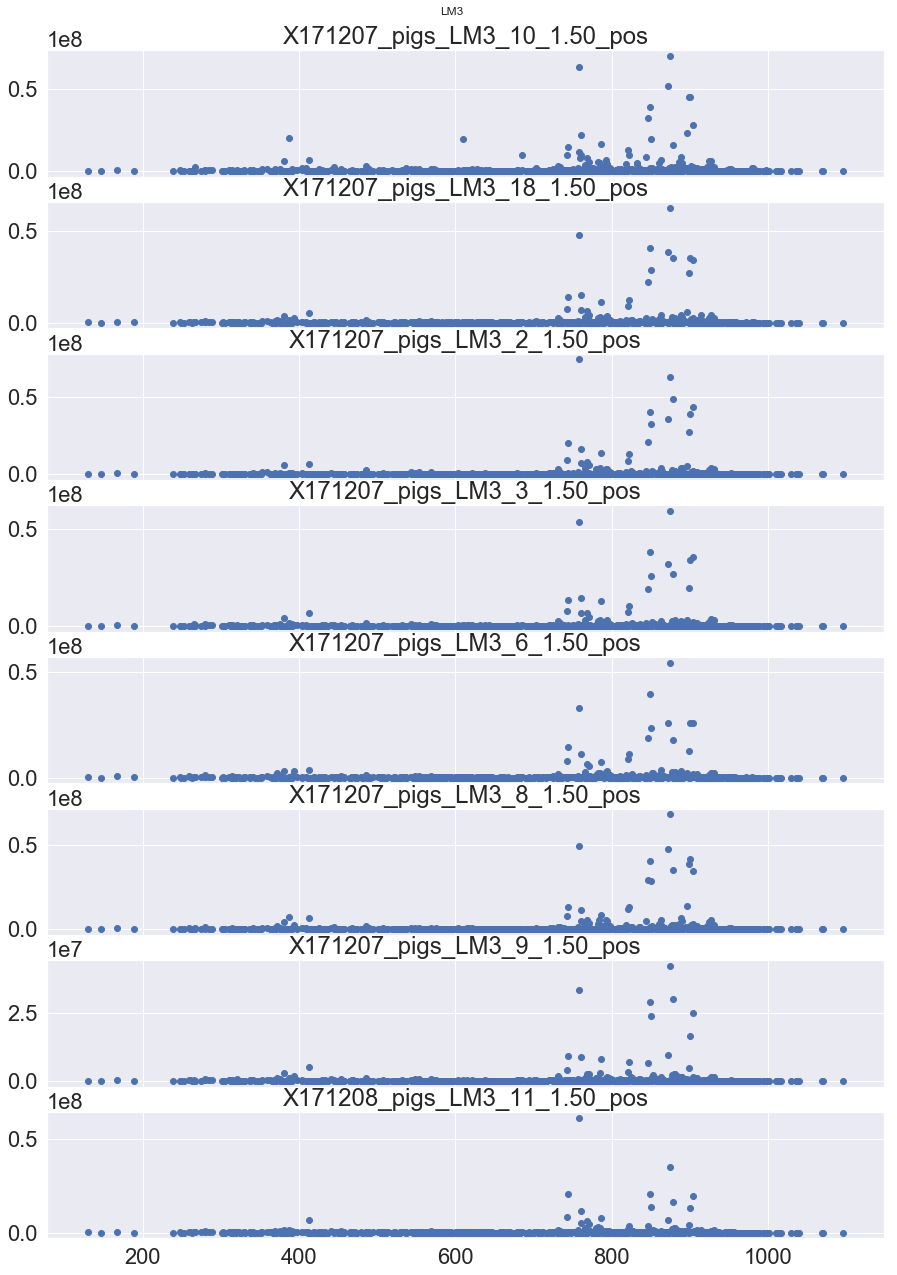

In [126]:
for part, columns in parts_mapping.items():

    f, axarr = plt.subplots(len(columns), sharex=True, figsize=(15,20))
    
    for ax, col in zip(axarr, columns):
        ax.scatter(data_cam_filt_rt_iso_df_annot.mz, data_cam_filt_rt_iso_df_annot[col])
        ax.set_title(col)
    
    f.suptitle(part)
    f.subplots_adjust(top=0.95)
    
    plt.show()

In [127]:
pigs_pattern = re.compile(r"_pigs_\S+?_(\S+?)_")


def get_pig_num(col_name):
    return int(pigs_pattern.search(col_name).group(1))
    
    
pigs_mapping = {}
for col in data_cam_filt_rt_iso_df_annot.columns:
    if "QC" in col:
        continue
    
    try:
        pigs_mapping.setdefault(get_pig_num(col), []).append(col) 
    except:
        pass


In [128]:
for pig, cols in sorted(pigs_mapping.items()):
    print("Pig {0}".format(pig))
    print(sorted(cols))

Pig 2
['X171207_pigs_BF1_2_1.50_pos', 'X171207_pigs_BF2_2_1.50_pos', 'X171207_pigs_BF3_2_1.50_pos', 'X171207_pigs_LM1_2_1.50_pos', 'X171207_pigs_LM2_2_1.50_pos', 'X171207_pigs_LM3_2_1.50_pos', 'X171208_pigs_scat1_2_1.100_pos', 'X171208_pigs_scat2_2_1.100_pos']
Pig 3
['X171207_pigs_BF1_3_1.50_pos', 'X171207_pigs_BF2_3_1.50_pos', 'X171207_pigs_BF3_3_1.50_pos', 'X171207_pigs_LM1_3_1.50_pos', 'X171207_pigs_LM2_3_1.50_pos', 'X171207_pigs_LM3_3_1.50_pos', 'X171208_pigs_scat1_3_1.100_pos', 'X171208_pigs_scat2_3_1.100_pos']
Pig 6
['X171207_pigs_BF1_6_1.50_pos', 'X171207_pigs_BF2_6_1.50_pos', 'X171207_pigs_BF3_6_1.50_pos', 'X171207_pigs_LM1_6_1.50_pos', 'X171207_pigs_LM2_6_1.50_pos', 'X171207_pigs_LM3_6_1.50_pos', 'X171208_pigs_scat1_6_1.100_pos', 'X171208_pigs_scat2_6_1.100_pos']
Pig 8
['X171207_pigs_BF2_8_1.50_pos', 'X171207_pigs_BF3_8_1.50_pos', 'X171207_pigs_LM1_8_1.50_pos', 'X171207_pigs_LM3_8_1.50_pos', 'X171208_pigs_BF1_8_1.50_pos', 'X171208_pigs_LM2_8_1.50_pos', 'X171208_pigs_scat1_8_1.

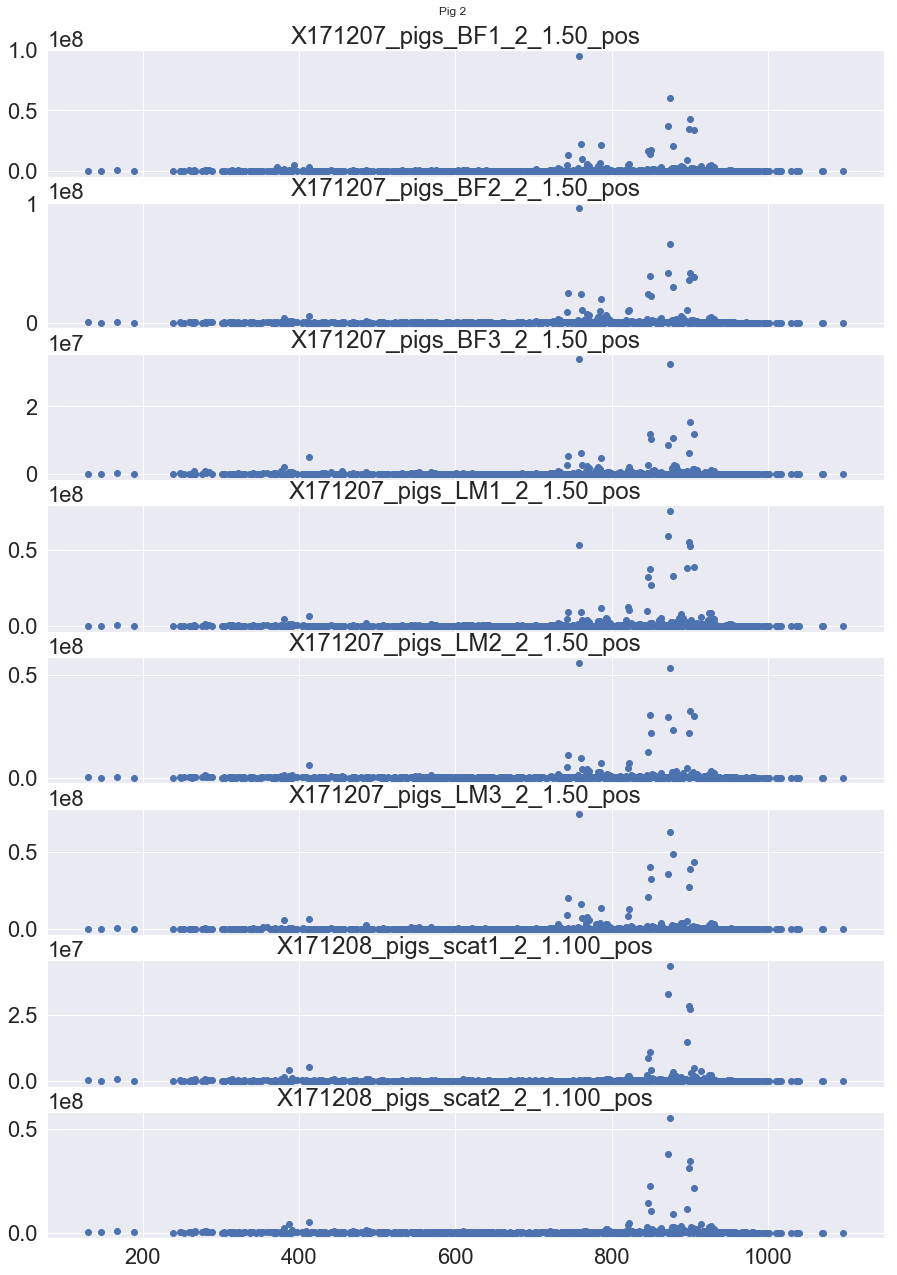

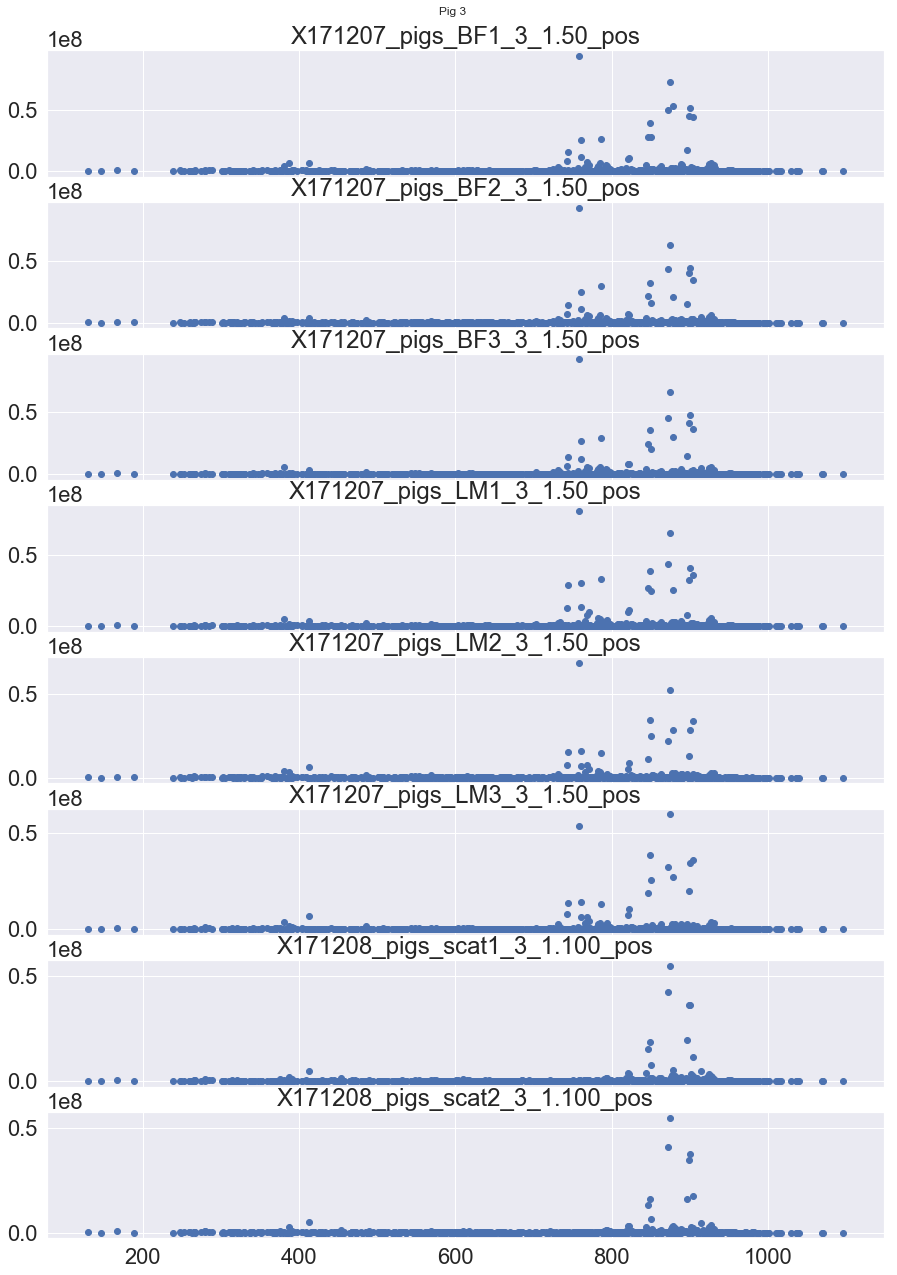

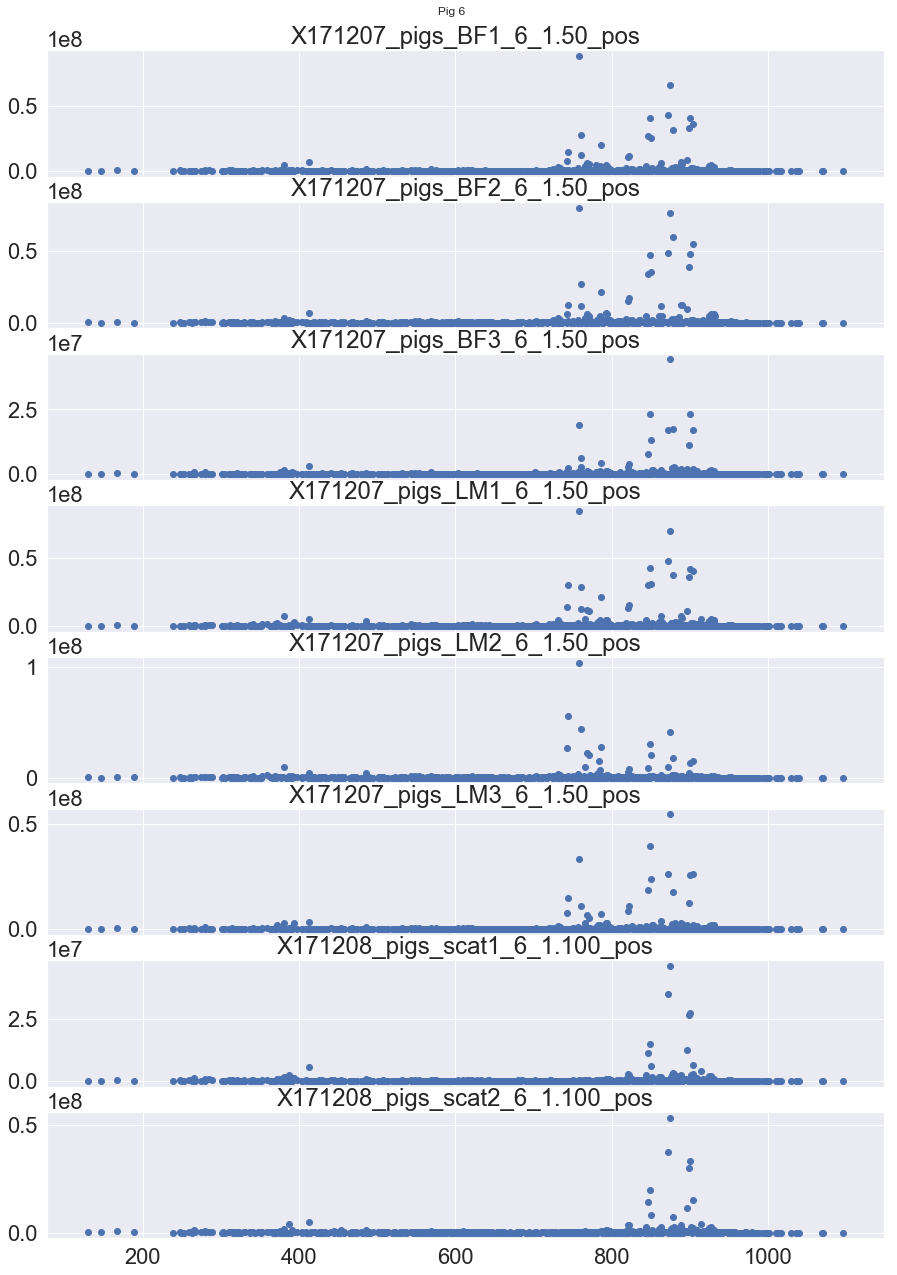

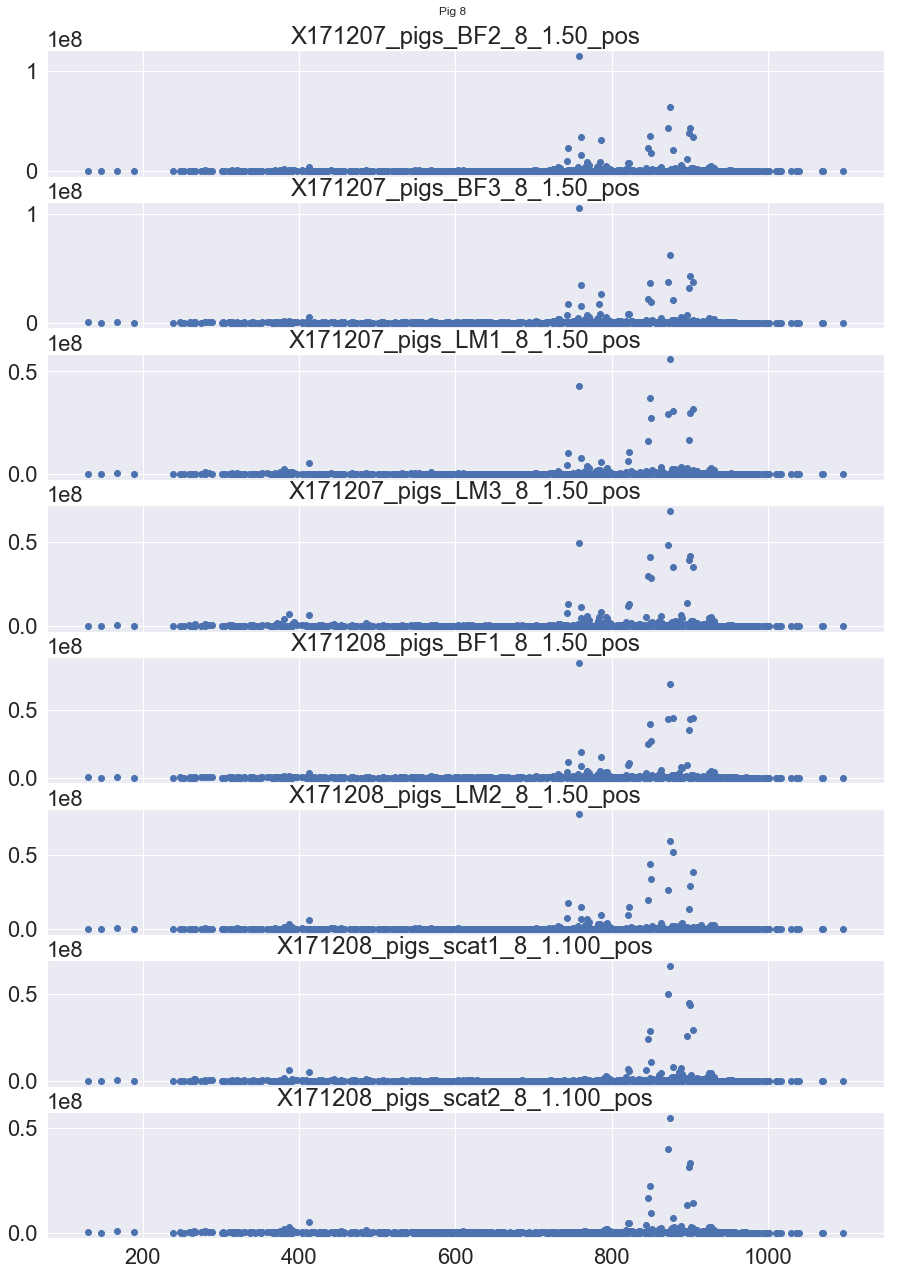

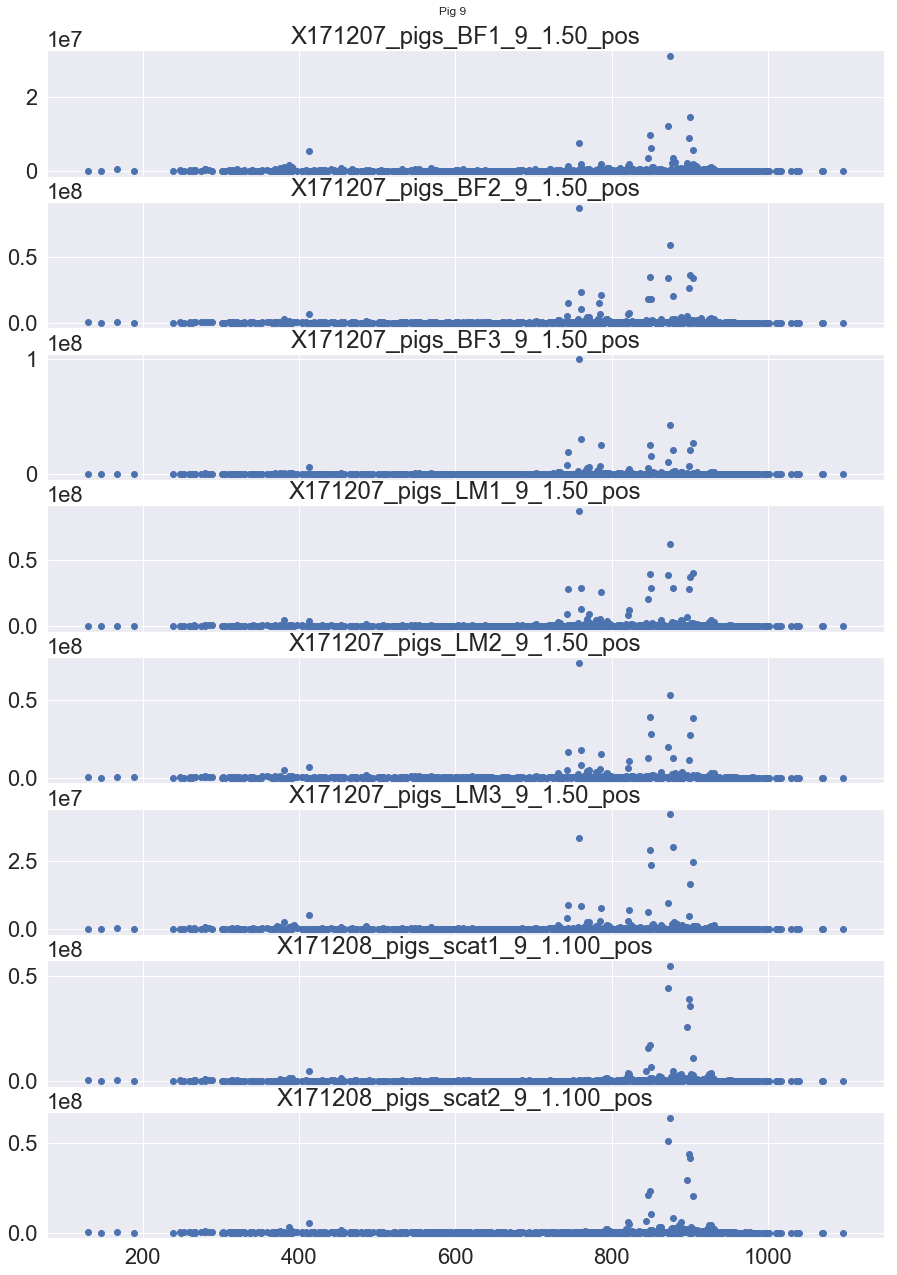

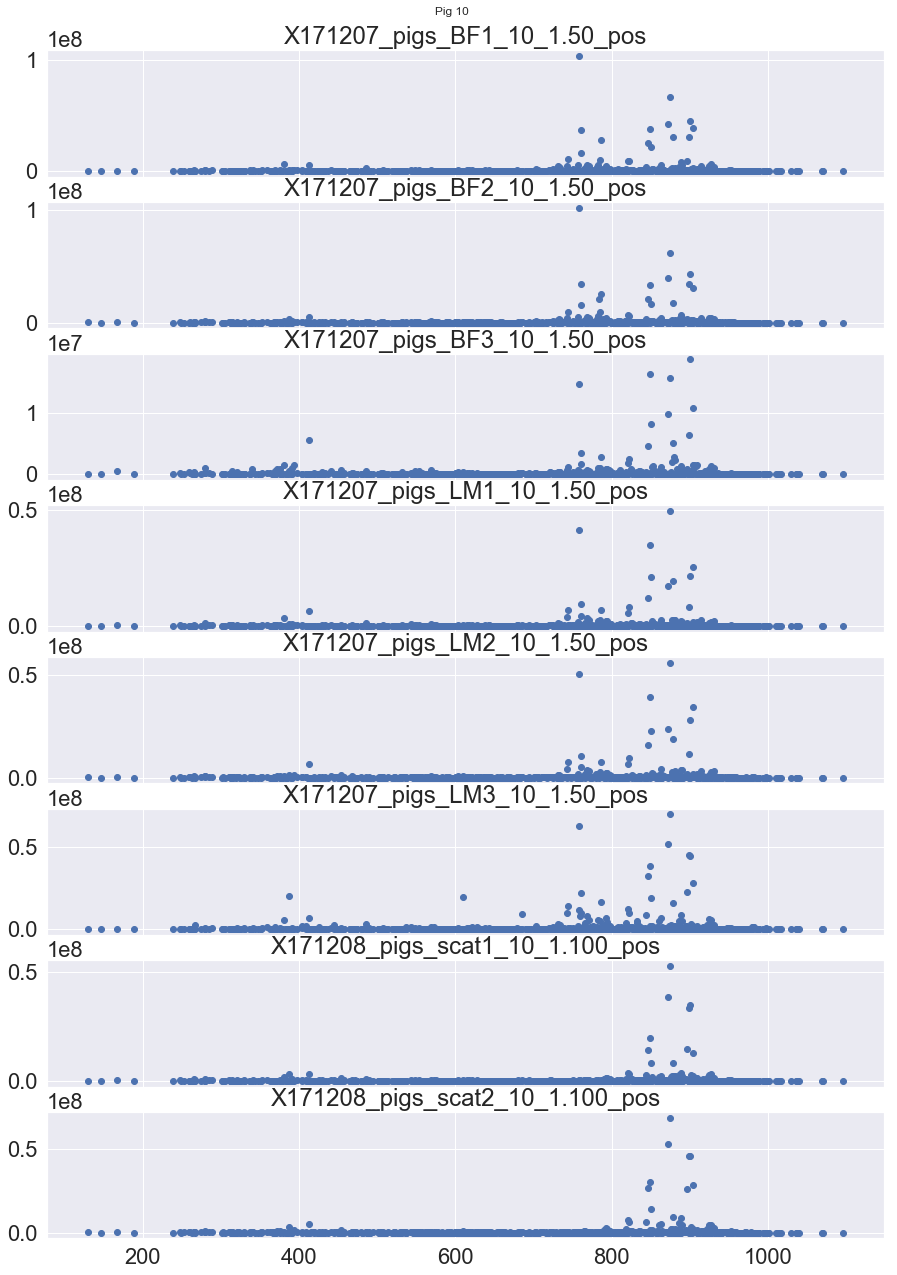

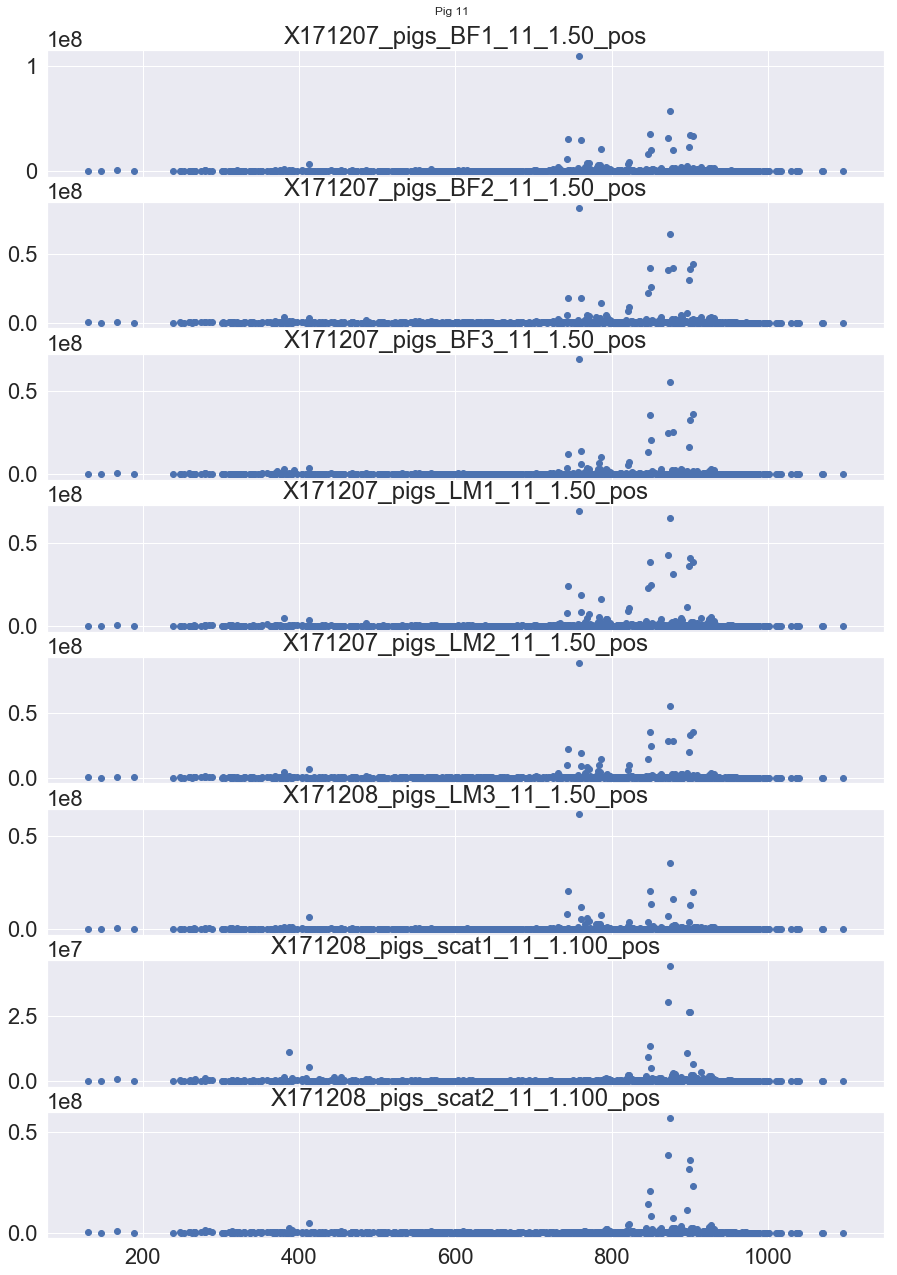

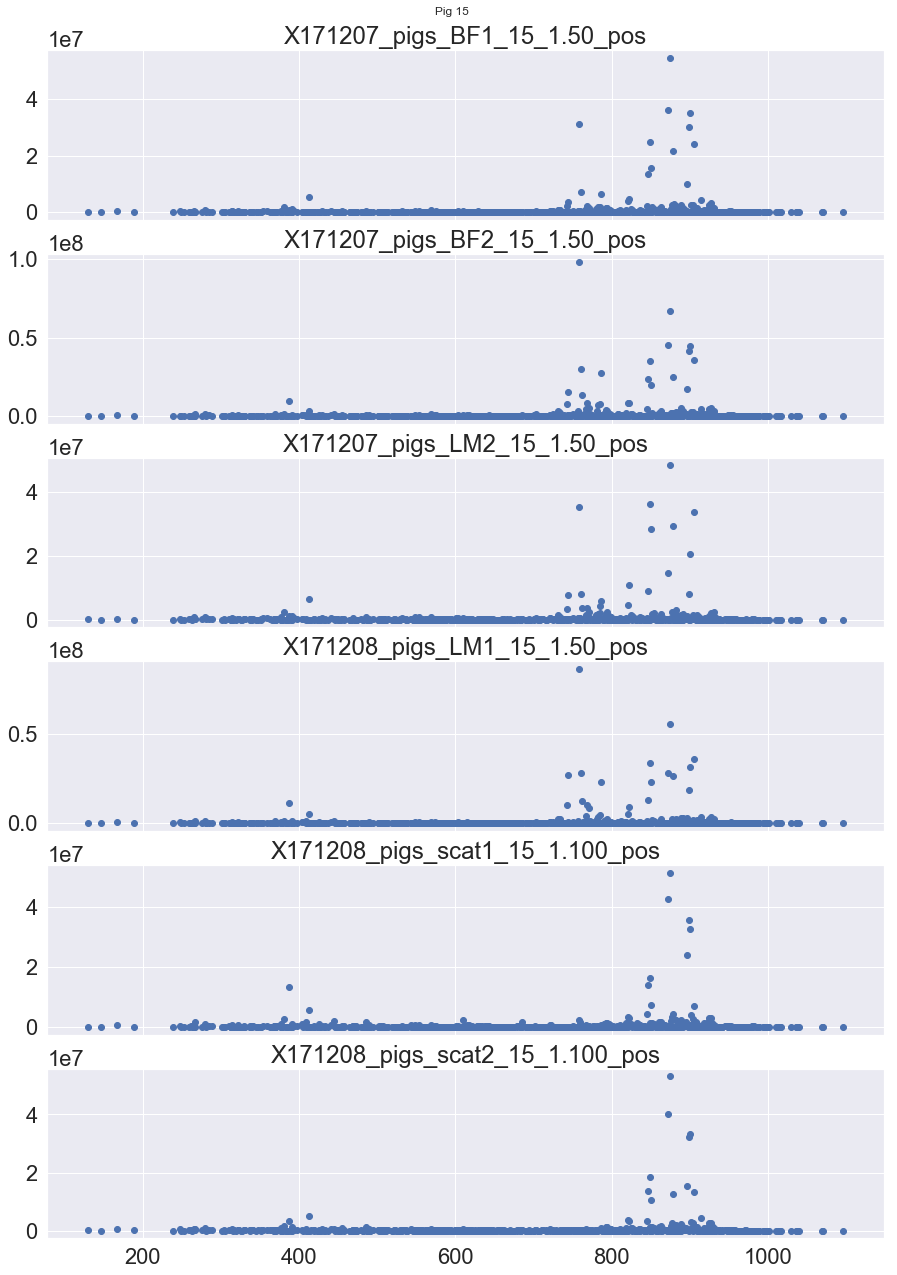

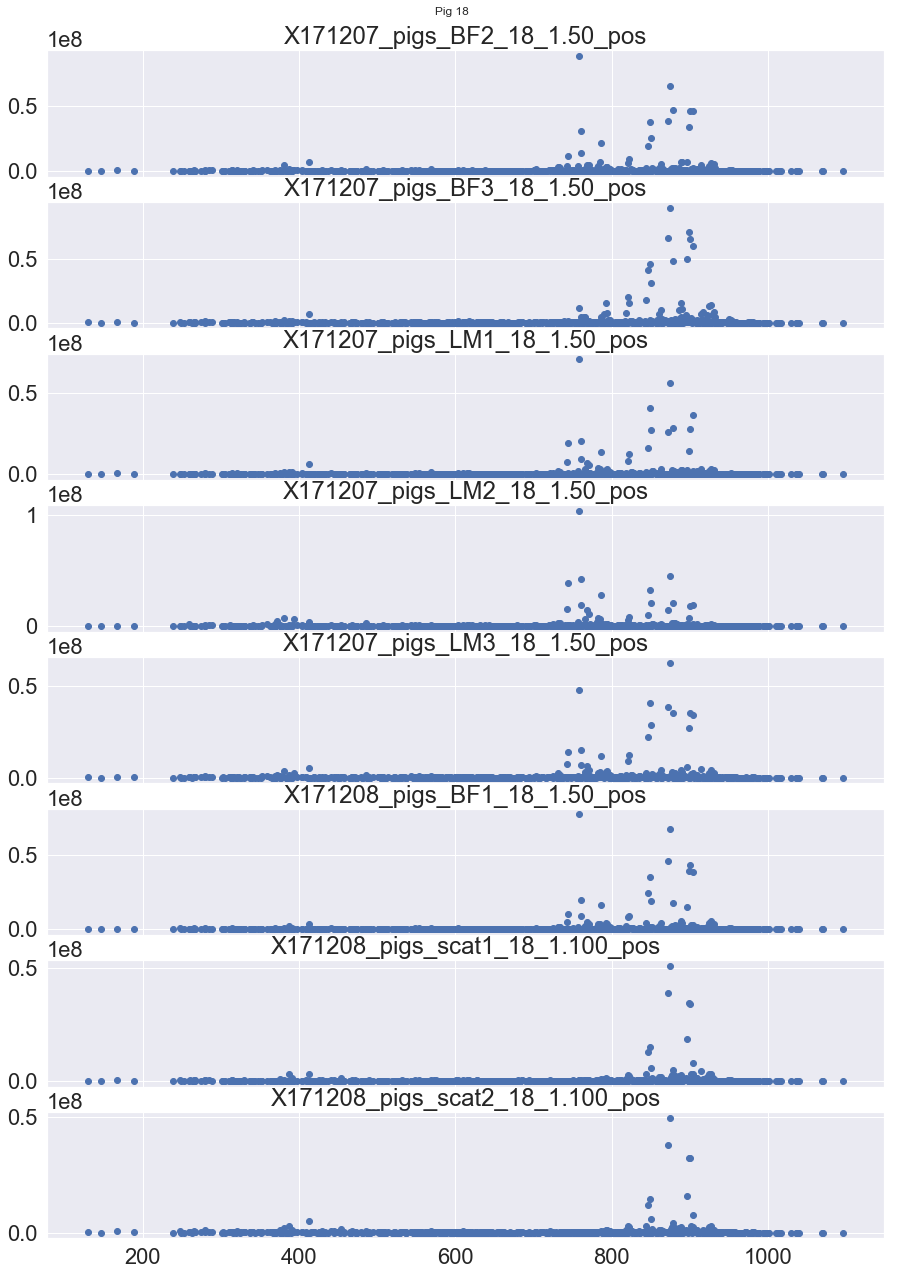

In [129]:
for pig, columns in sorted(pigs_mapping.items()):
    
    columns = sorted(columns)

    f, axarr = plt.subplots(len(columns), sharex=True, figsize=(15,20))
    
    for ax, col in zip(axarr, columns):
        ax.scatter(data_cam_filt_rt_iso_df_annot.mz, data_cam_filt_rt_iso_df_annot[col])
        ax.set_title(col)
    
    f.suptitle("Pig {0}".format(pig))
    f.subplots_adjust(top=0.95)
    
    plt.show()

In [59]:
samples = data_cam_filt_rt_iso_df_annot[[col for col in data_cam_filt_rt_iso_df_annot.columns if col.startswith("X") and "QC" not in col]]
samples_columns = list(samples.columns)
scat_column = samples_columns[0]
samples_columns.pop(0)
samples_columns.insert(samples_columns.index('X171208_pigs_scat1_18_1.100_pos'), scat_column)
samples =samples[samples_columns]

In [69]:
samples_columns = list(samples.columns)
renamed_columns = []

for col in samples_columns:

    pig = get_pig_num(col)
    part = get_pig_part(col)
    
    renamed_columns.append("Part: {}; Pig: {}".format(part, pig))

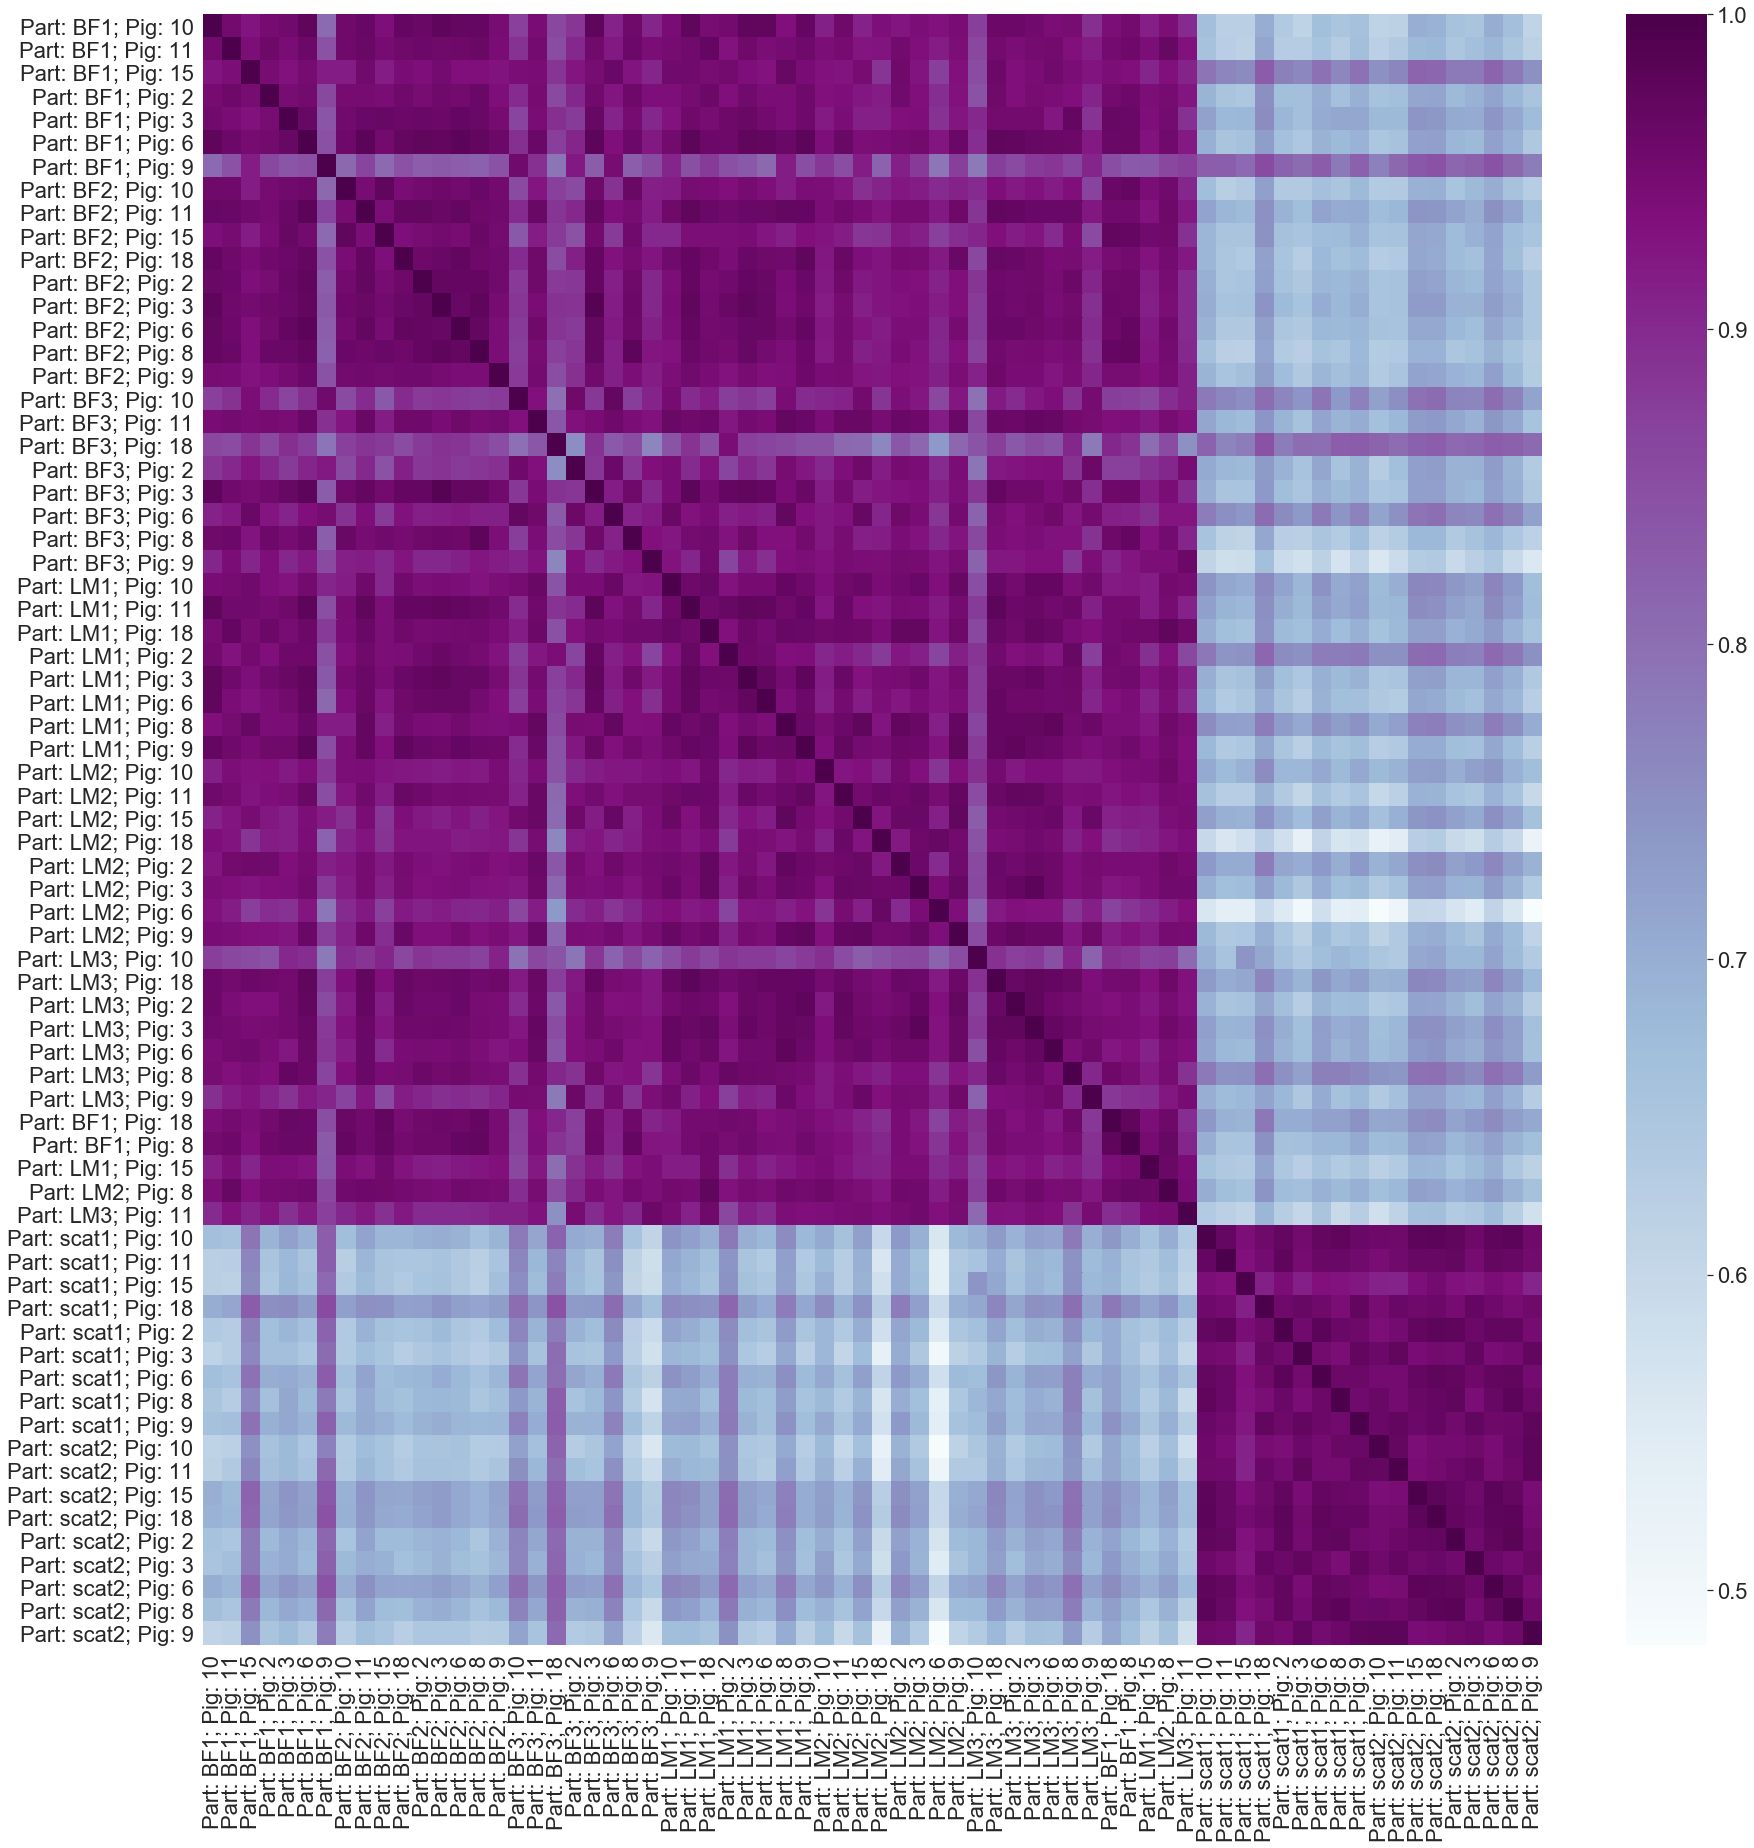

In [85]:
import seaborn

plt.gcf().set_size_inches(30, 30)

ax = plt.gca()
seaborn.set(font_scale=2) 
seaborn.heatmap(samples.corr(), cmap="BuPu", xticklabels=renamed_columns, yticklabels=renamed_columns)
pass


In [48]:
def pig_vector(variables):
    X = []

    for pig, cols in pigs_mapping.items():
        if pig == 15:
            continue
        
        x = []
        
        for var_name in variables:
            for col in cols:
                if var_name in col:
                    x.append(data_cam_filt_rt_iso_df_annot[col])
    
        X.append(np.concatenate(x))
        
    return np.array(X)

In [49]:
def pigs_vectors(variables, dependents):
    return pig_vector(variables), pig_vector(dependents)

In [50]:
def train_on(variables, dependents, alpha = 0, plot_iterations = False, print_mse = False):
    X, Y = pigs_vectors(variables, dependents)
    
    loo = LeaveOneOut()
    pigs_mse = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        linreg = LinearRegression() if alpha == 0 else Ridge(alpha=alpha, random_state = 33)
        linreg.fit(X_train, Y_train)
        square_errors =np.square(Y_test - linreg.predict(X_test))
        mse = np.mean(square_errors)
        pigs_mse.append(mse)
        if plot_iterations:
            print("MSE", mse)
            plt.plot(Y_test.ravel(), label='True', c='b')
            plt.plot(linreg.predict(X_test).ravel(), label='Prediction', alpha=0.5, c='r')
            plt.legend()
            plt.show()

    average_mse = np.mean(pigs_mse)
    std_mse = np.std(pigs_mse)
    
    if print_mse:
        print("Average MSE", np.mean(pigs_mse))
        print("Std MSE", np.std(pigs_mse))
    
    return average_mse, std_mse


In [51]:
def train_mean(feats):
    mses = []
    feat_matrix = pig_vector(feats)
    for i in range(feat_matrix.shape[0]):
        test_vector = feat_matrix[i]        
        train_matrix = np.delete(feat_matrix, i, 0)
        mean = np.mean(train_matrix, axis = 0)
        mses.append(np.mean(np.square(test_vector-mean)))
    return np.mean(mses), np.std(mses)

In [52]:
train_mean(["scat1"])

(0.15707937987386728, 0.04144185818266933)

In [53]:
train_mean(["scat2"])

(0.15566408435886014, 0.026767412075084863)

In [60]:
train_on(["BF1", "BF2", "BF3", "LM1", "LM2", "LM3"], ["scat1"])

Average MSE 0.17921808835006067
Std MSE 0.05537281508457712


(0.17921808835006067, 0.05537281508457712)

In [61]:
train_on(["BF1", "BF2", "BF3", "LM1", "LM2", "LM3"], ["scat2"])

Average MSE 0.20902033465684372
Std MSE 0.08714539851968356


(0.20902033465684372, 0.08714539851968356)

In [105]:
mses = []
stds = []
alphas = np.logspace(-6, 6, num=13)
for alpha in alphas:
    mse, std = train_on(["BF1", "BF2", "BF3", "LM1", "LM2", "LM3"], ["scat1"], alpha=alpha)
    stds.append(std)
    mses.append(mse)

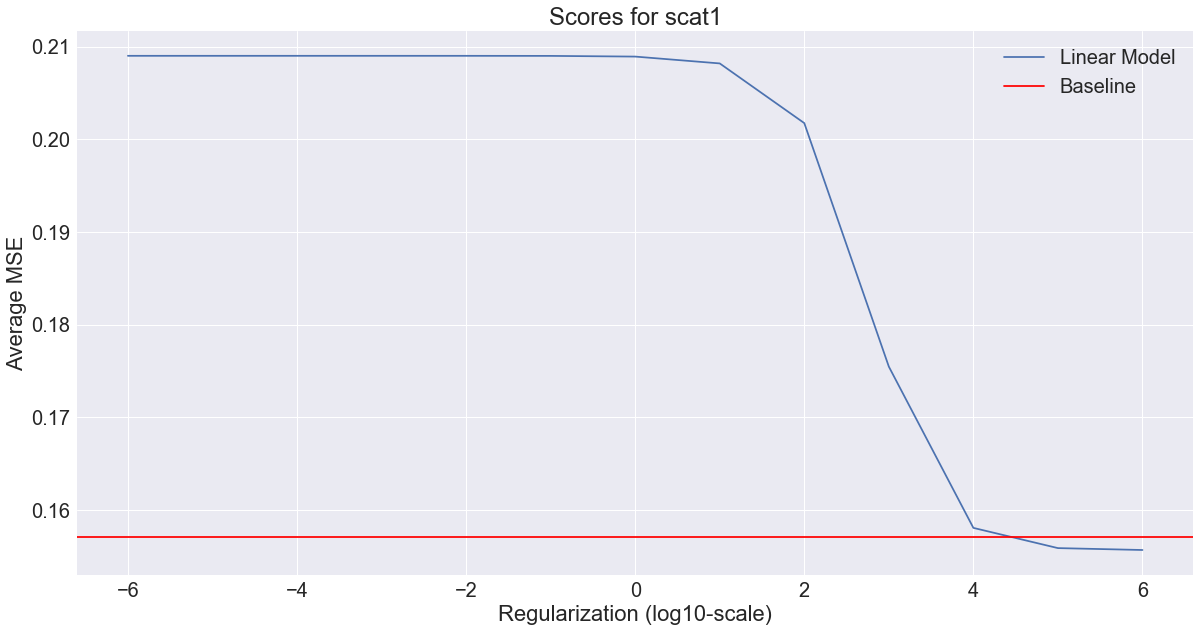

In [115]:
plt.plot(np.log10(alphas), mses, label='Linear Model')
plt.axhline(train_mean(["scat1"])[0], c='r', label='Baseline')
plt.xlabel("Regularization (log10-scale)")
plt.ylabel("Average MSE")
plt.legend()
plt.title("Scores for scat1")
plt.gcf().set_size_inches(20, 10)
seaborn.set(font_scale=2)



In [112]:
mses = []
stds = []
alphas = np.logspace(-6, 6, num=13)
for alpha in alphas:
    mse, std = train_on(["BF1", "BF2", "BF3", "LM1", "LM2", "LM3"], ["scat2"], alpha=alpha)
    stds.append(std)
    mses.append(mse)

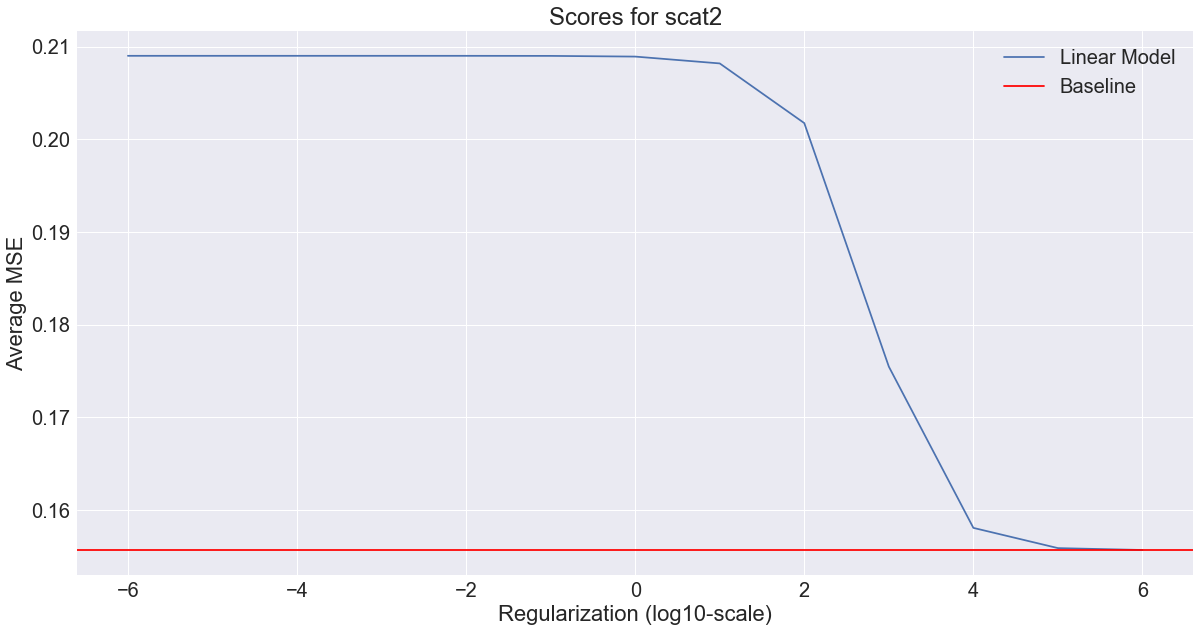

In [113]:
plt.plot(np.log10(alphas), mses, label='Linear Model')
plt.axhline(train_mean(["scat2"])[0], c='r', label='Baseline')
plt.xlabel("Regularization (log10-scale)")
plt.ylabel("Average MSE")
plt.legend()
plt.title("Scores for scat2")
plt.gcf().set_size_inches(20, 10)
seaborn.set(font_scale=2)



In [90]:
stds

[0.08731018794233872,
 0.08731018709787353,
 0.08731017865322391,
 0.08731009420685525,
 0.08730924975577162,
 0.08730080650528704,
 0.08721649984677057,
 0.08638583193544212,
 0.07915732109643143,
 0.05000737530521625,
 0.029997929792001693,
 0.027091679412053427,
 0.02679979881055988]

In [64]:
alphas

array([ 1., inf, inf])

In [291]:
feats =  ["BF1", "BF2", "BF3", "LM1", "LM2", "LM3", "scat1", "scat2"]

for i in range(len(feats)):
    dependent_feat = feats[i]
    variable_feats = list(feats)
    del variable_feats[i]
        
    mean_mse, mean_std = train_mean([dependent_feat])
    train_mse, train_std = train_on(variable_feats, [dependent_feat], print_mse=False)
    print(dependent_feat, mean_mse-train_mse, mean_std-train_std)
    print()

BF1 -0.0695687504175681 0.006359299389175066

BF2 -0.009357817946300445 -0.01336228616869594

BF3 -0.10246230319634886 0.05346785948904098

LM1 -0.014410389850604721 -0.0016168365138615123

LM2 -0.0008953818221515142 -0.003966369723928567

LM3 0.02110983683966272 0.03731539436610898

scat1 -0.018231674379656226 -0.014376871146989621

scat2 -0.04761965910923771 -0.052344179245734576



In [299]:
most_popular_peaks = []
for feat in feats:
    feat_vectors = pig_vector([feat])
    stds = np.std(feat_vectors, axis=0)
    most_popular_peaks += np.argsort(stds)[::-1][:30].tolist()

from collections import Counter
Counter(most_popular_peaks).most_common()

[(728, 8),
 (126, 6),
 (475, 6),
 (515, 5),
 (506, 5),
 (128, 5),
 (270, 4),
 (271, 4),
 (30, 4),
 (619, 4),
 (742, 4),
 (8, 3),
 (531, 3),
 (290, 3),
 (304, 3),
 (569, 3),
 (317, 3),
 (66, 3),
 (336, 3),
 (139, 3),
 (633, 3),
 (387, 3),
 (156, 3),
 (682, 3),
 (702, 3),
 (449, 3),
 (706, 3),
 (778, 2),
 (48, 2),
 (292, 2),
 (44, 2),
 (559, 2),
 (186, 2),
 (54, 2),
 (651, 2),
 (580, 2),
 (69, 2),
 (339, 2),
 (600, 2),
 (348, 2),
 (3, 2),
 (618, 2),
 (18, 2),
 (368, 2),
 (578, 2),
 (399, 2),
 (150, 2),
 (675, 2),
 (698, 2),
 (208, 2),
 (163, 2),
 (727, 2),
 (740, 2),
 (487, 2),
 (680, 2),
 (762, 2),
 (127, 2),
 (775, 1),
 (267, 1),
 (781, 1),
 (528, 1),
 (529, 1),
 (530, 1),
 (789, 1),
 (22, 1),
 (538, 1),
 (795, 1),
 (549, 1),
 (552, 1),
 (811, 1),
 (648, 1),
 (818, 1),
 (819, 1),
 (314, 1),
 (315, 1),
 (830, 1),
 (64, 1),
 (737, 1),
 (73, 1),
 (843, 1),
 (77, 1),
 (525, 1),
 (696, 1),
 (82, 1),
 (14, 1),
 (89, 1),
 (602, 1),
 (442, 1),
 (787, 1),
 (117, 1),
 (376, 1),
 (636, 1),
 (490,

In [246]:
train_on(["BF1", "BF2", "BF3", "LM1", "LM2", "LM3"], ["scat2"])

Average MSE 0.15568652711779418
Std MSE 0.02679979881055988


(0.15568652711779418, 0.02679979881055988)

In [265]:
train_on(["BF1"], ["BF3"])

Average MSE 0.4901554647323314
Std MSE 0.26920240481872315


(0.4901554647323314, 0.26920240481872315)

In [248]:
train_on(["BF1", "BF2", "BF3", "LM1", "LM2", "LM3"], ["scat1"])

Average MSE 0.1570691295313167
Std MSE 0.04145838259798277


(0.1570691295313167, 0.04145838259798277)

In [249]:
train_on(["BF1", "BF2", "BF3", "LM1", "LM2", "LM3"], ["scat1", "scat2"])

Average MSE 0.15637782832455543
Std MSE 0.017730119140470988


(0.15637782832455543, 0.017730119140470988)

In [250]:
train_on(["scat1", "scat2"], ["BF1", "BF2", "BF3", "LM1", "LM2", "LM3"])

Average MSE 0.2943210209099204
Std MSE 0.0965831221409461


(0.2943210209099204, 0.0965831221409461)

In [212]:
train_on(["scat1"], ["scat2"])

Average MSE 0.2561663279044818
Std MSE 0.03309179684581746


(0.2561663279044818, 0.03309179684581746)

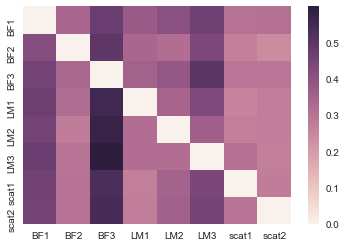

In [205]:
feats =  ["BF1", "BF2", "BF3", "LM1", "LM2", "LM3", "scat1", "scat2"]
mse_heatmap = np.zeros((len(feats), len(feats)))

for i, feat_1 in enumerate(feats):
    for j, feat_2 in enumerate(feats):
        if i!=j:
            average_mse, std_mse = train_on([feat_1], [feat_2], print_mse=False)
            mse_heatmap[i,j] = average_mse
            
seaborn.heatmap(mse_heatmap, xticklabels=feats, yticklabels=feats)

In [201]:
mse_heatmap

array([[0.38427054, 0.27469493, 0.47736802, 0.29604593, 0.32142364,
        0.39163885, 0.25135878, 0.24713664],
       [0.38433867, 0.27469111, 0.47737554, 0.29603652, 0.32140869,
        0.39164427, 0.25135738, 0.24712395],
       [0.38432825, 0.27470732, 0.47714861, 0.29605132, 0.3214248 ,
        0.39167865, 0.25135967, 0.24712759],
       [0.38434815, 0.27469903, 0.47737924, 0.29600331, 0.32141072,
        0.39163276, 0.25135211, 0.24712703],
       [0.38435047, 0.27469276, 0.47739037, 0.29603318, 0.32137402,
        0.39162302, 0.25135705, 0.24712359],
       [0.3843344 , 0.27468403, 0.47739915, 0.29600478, 0.32137862,
        0.39151298, 0.25135853, 0.2471361 ],
       [0.38434453, 0.27469888, 0.47737049, 0.2960299 , 0.32141075,
        0.39164731, 0.25134945, 0.24712758],
       [0.384347  , 0.27469672, 0.47737786, 0.29603478, 0.3214128 ,
        0.39164838, 0.25136105, 0.24710894]])

In [141]:
def compare_parts(part_1, part_2):
    parts_mse = []

    for part1, part2 in zip(*pigs_vectors([part_1], [part_2])):
        square_errors =np.abs(part1.ravel() - part2.ravel())
        mse = np.mean(square_errors)
        parts_mse.append(mse)

    print("Average MSE", np.mean(parts_mse))
    print("Std MSE", np.std(parts_mse))

In [142]:
compare_parts("BF1", "BF2")

Average MSE 0.4090785531590789
Std MSE 0.17405596689006456


In [143]:
compare_parts("scat1", "scat2")

Average MSE 0.28573980329418747
Std MSE 0.041141117141545114


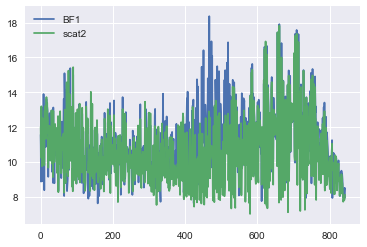

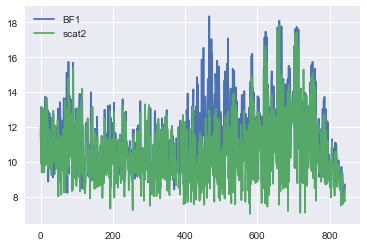

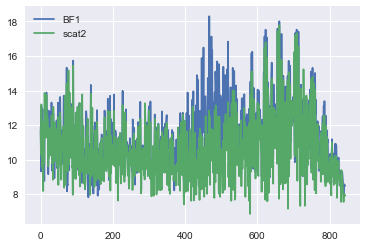

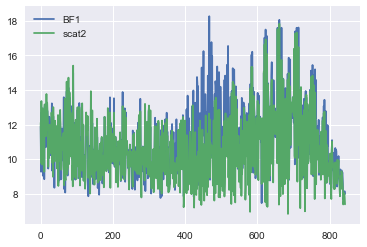

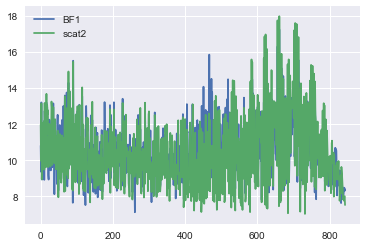

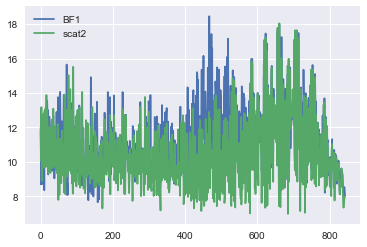

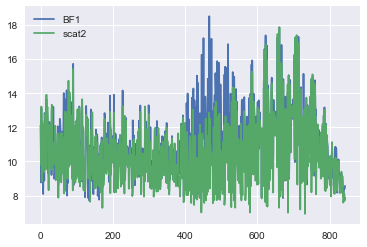

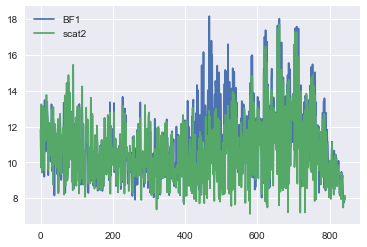

In [160]:
for bf, scat in zip(*pigs_vectors(["BF1"], ["scat2"])):
    plt.plot(bf.ravel(), label='BF1')
    plt.plot(scat.ravel(), label='scat2')
    plt.legend()
    plt.show()

In [50]:
annot_data

,lm_id,adduct,ppm
1,NaN,M+H,NaN
1,LMFA11000592,M+NH4,-3.021140
1,LMFA11000636,M+NH4,-3.021140
1,LMFA11000637,M+NH4,-3.021140
1,LMFA11000638,M+NH4,-3.021140
1,LMFA11000659,M+NH4,-3.021140
1,NaN,M+Na,NaN
2,NaN,M+H,NaN
2,NaN,M+NH4,NaN
2,NaN,M+Na,NaN


In [51]:
annot_data.lm_id.isnull().sum()

7266

In [55]:
counts = {}
for ind, data in annot_data.groupby(annot_data.index):
    if all(data.lm_id.isnull()):
        counts[0] = counts.get(0, 0) + 1
    else:
        data = data[~data.lm_id.isnull()]
        n = len(data)
        counts[n] = counts.get(n, 0) + 1

<BarContainer object of 109 artists>

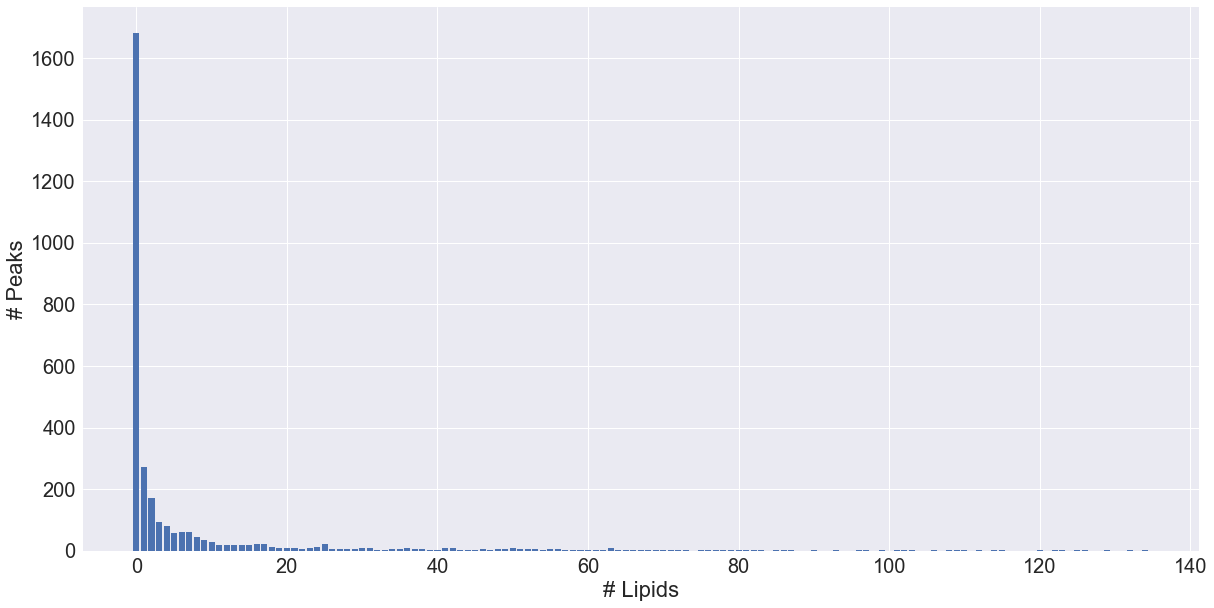

In [57]:
x, y = zip(*counts.items())
plt.gcf().set_size_inches(20, 10)
seaborn.set(font_scale=2)
plt.xlabel("# Lipids")
plt.ylabel("# Peaks")
plt.bar(x, y)

In [82]:
len(np.unique(annot_data.index))

3078

In [73]:
counts

{0: 1681,
 1: 271,
 2: 172,
 3: 92,
 4: 82,
 5: 57,
 6: 60,
 7: 62,
 8: 44,
 9: 34,
 10: 27,
 11: 18,
 12: 20,
 13: 19,
 14: 20,
 15: 20,
 16: 23,
 17: 22,
 18: 11,
 19: 8,
 20: 10,
 21: 9,
 22: 6,
 23: 8,
 24: 12,
 25: 21,
 26: 5,
 27: 6,
 28: 6,
 29: 7,
 30: 8,
 31: 8,
 32: 3,
 33: 3,
 34: 5,
 35: 5,
 36: 10,
 37: 7,
 38: 6,
 39: 1,
 40: 2,
 41: 9,
 42: 10,
 43: 2,
 44: 3,
 45: 2,
 46: 6,
 47: 3,
 48: 7,
 49: 5,
 50: 8,
 51: 5,
 52: 7,
 53: 7,
 54: 2,
 55: 6,
 56: 5,
 57: 1,
 58: 4,
 59: 2,
 60: 3,
 61: 2,
 62: 2,
 63: 8,
 64: 1,
 65: 2,
 66: 2,
 67: 3,
 68: 3,
 69: 1,
 70: 3,
 71: 3,
 72: 1,
 73: 2,
 75: 4,
 76: 2,
 77: 3,
 78: 1,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 83: 2,
 85: 1,
 86: 2,
 87: 1,
 90: 1,
 93: 2,
 96: 1,
 97: 2,
 99: 1,
 101: 2,
 102: 1,
 103: 1,
 106: 2,
 108: 3,
 109: 3,
 110: 1,
 112: 1,
 114: 3,
 115: 2,
 120: 2,
 122: 1,
 123: 2,
 125: 2,
 126: 1,
 129: 1,
 132: 1,
 134: 1}

In [75]:
len(data_cam_filt_rt_iso_df_annot)

844

In [76]:
3078 - 1681

1397